In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

We will read the preprocessed data from CSV file selected_sba_loans_data.csv into a pandas DataFrame df_cleaned.

In [2]:
df_cleaned = pd.read_csv("selected_sba_loans_data.csv")
df_cleaned

,ChgOffPrinGr,Term,DisbursementGross,UrbanRural,RevLineCr,LowDoc,BankState,State,NAICS,MIS_Status
0,-0.211808,-0.277691,60000.0,0,0,1,38,15,831,0
1,-0.211808,-0.595858,40000.0,0,0,1,18,15,1233,0
2,-0.211808,0.994975,287000.0,0,0,0,18,15,1157,0
3,-0.211808,-0.595858,35000.0,0,0,1,39,36,0,0
4,-0.211808,1.790392,229000.0,0,0,0,11,9,0,0
...,...,...,...,...,...,...,...,...,...,...
613718,-0.211808,-0.277691,79000.0,0,0,1,8,43,0,0
613719,-0.211808,-0.595858,85000.0,0,1,0,17,35,832,0
613720,-0.211808,0.040475,300000.0,0,0,0,5,4,436,0
613721,0.625731,-0.595858,75000.0,0,0,1,14,11,0,1


We will now define our feature set and tearget variables and split data to 80% train and 20% test set. Even though DisbursementGross is excluded from the model features, it is essential for computing the financial impact of prediction errors, such as the cost of false positives or the benefits of true positives.

In [3]:
# Define your feature set and target, exclude DisbursementGross
X = df_cleaned[['ChgOffPrinGr', 'Term', 'UrbanRural', 'RevLineCr', 'LowDoc', 'BankState', 'State', 'NAICS']]
y = df_cleaned['MIS_Status']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Store DisbursementGross separately for later use
disbursement_test = df_cleaned.loc[X_test.index, 'DisbursementGross']  # Align DisbursementGross with X_test

In the MIS_Status Column, we have encoded the values as follows: **0 = PIF, 1 = CHGOFF**.

In [4]:
y_train.value_counts()

MIS_Status
0    402144
1     88834
Name: count, dtype: int64

The dataset is highly imbalanced, with far more loans being Paid in Full, PIF(0) compared to those that Defaulted, CHGOFF(1). Class imbalance can lead to biased models that favor the majority class, resulting in poor performance for predicting defaults. </br>

Therefore, we will balance the training dataset by using **SMOTE (Synthetic Minority Oversampling Technique)**. SMOTE generates synthetic examples of the minority class (1 - CHGOFF) by interpolating between existing minority class instances using the kNN method. </br>

This ensures that the training data has an equal number of samples for both classes, improving the model's ability to identify defaults.

In [5]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE(random_state=42)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [6]:
y_train.value_counts()

MIS_Status
1    402144
0    402144
Name: count, dtype: int64

The training set is now balanced, with equal numbers of PIF and CHGOFF values.

### Function to calculate Net Profit

The calculate_net_profit function evaluates the financial performance of a model’s predictions by calculating the net profit based on actual loan statuses (y_true), predicted outcomes (y_pred), and loan disbursement amounts. </br>

By iterating through each loan, the function aggregates profits and losses to return the total net profit for a model. This approach provides a comprehensive measure of a model’s financial impact, enabling the SBA to prioritize models that optimize loan approvals and minimize losses, making it a critical tool for aligning predictive outcomes with real-world financial goals.

In [7]:
def calculate_net_profit(y_true, y_pred, disbursement_gross):
    """
    Calculate the net profit based on predictions, ground truth, and disbursement gross amounts.

    Parameters:
    - y_true: Array of true labels (0 for Default, 1 for Paid in full)
    - y_pred: Array of predicted labels (0 for Default, 1 for Paid in full)
    - disbursement_gross: Array of disbursement gross amounts corresponding to each loan

    Returns:
    - net_profit: The total net profit based on the cost-benefit matrix.
    """
    # Convert inputs to numpy arrays for easy indexing
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    disbursement_gross = np.array(disbursement_gross)

    # Calculate profits and costs for each prediction
    net_profit = 0
    for i in range(len(y_true)):
        if y_true[i] == 1 and y_pred[i] == 1:  # True Positive: correctly granted loan
            net_profit += 0.05 * disbursement_gross[i]
        elif y_true[i] == 0 and y_pred[i] == 1:  # False Positive: incorrectly granted loan
            net_profit += -5 * (0.05 * disbursement_gross[i])

    return net_profit

# Dictionary to store Net Profit for each model
net_profits = {}

### Python Class to calculate Optimal Probability Cut-Off and Plot Gains Chart & Lift Chart 

#### Gains Chart: 
The Gains Chart visualizes the cumulative net profit achieved by progressively approving loans ranked by their predicted probability of being paid in full.

1. X-Axis: Represents the number of loan applications, ordered by the predicted likelihood of being repaid (from highest to lowest).

2. Y-Axis: Represents the cumulative net profit from approving loans in sequence, where loans with higher predicted probabilities of being paid off are approved first. 

3. Curve: The curve shows how cumulative net profit increases as you approve more loans, ranked by their predicted likelihood.

4. What the Gains Chart Tells Us: 
    - Increasing Net Profit: The chart should ideally show an upward trend, indicating that approving higher-risk loans (with lower probabilities of repayment) leads to progressively higher net profit, at least up to the optimal point.

5. Insights: If the curve is steep early on and then flattens out, it means that approving the top-ranked loans (those with high probabilities of repayment) generates most of the profit. If the curve continues to rise with a smaller slope, approving loans with lower probabilities (riskier) can still be beneficial but will eventually yield diminishing returns.

#### Lift Chart: 
The Lift Chart compares the cumulative net profit of your model against a random selection of loan applications.
Key Properties:

1. X-Axis: Represents the number of loan applications, again ordered by their predicted probabilities of repayment.

2. Y-Axis: Represents the cumulative net profit for both the model (from ranked predictions) and a random selection (from randomly selecting loans).

3. Model Net Profit Curve: This curve shows the cumulative net profit based on the model’s predictions, where loans with higher predicted probabilities are approved first. 

4. Random Selection Curve: This dashed line represents the cumulative net profit you would achieve if you randomly selected loans, assuming all loans have the same probability of being paid off. It's a baseline showing what would happen without the model's help.

5. What the Lift Chart Tells Us:
    - Model vs. Random Performance: The distance between the two curves indicates the "lift" the model provides over random selection. If the model curve is consistently above the random curve, this shows that the model is effectively identifying loans that are more likely to be repaid, which leads to higher cumulative profit.
    - Lift: The greater the gap between the two curves, the better your model is at identifying profitable loans, as it allows you to approve loans with higher net profits than random selection would have. 
    - Flat Lift Curve: If the model curve closely follows the random selection curve, it suggests the model is not adding much value beyond random selection.

6. Insights: A steep model curve early on indicates that the model is very good at identifying high-value loans early in the approval process, generating higher profits upfront. A flatter model curve means the model isn’t providing much lift over random selection, indicating it is not identifying profitable loans effectively.


#### Key Outputs
1. Net Profit Point (Red Line): This vertical line marks the point at which cumulative net profit is maximized. It helps identify how far into the ranked list of loan applications you should go to achieve the maximum net profit. The area to the left of this line represents the set of loan applications that, when approved, maximize the net profit. 

2. Optimal Cut-Off Probability: The optimal probability cut-off (as indicated by the red line on the Gains Chart) shows the predicted probability at which loans should be approved to achieve the maximum net profit. In the context of the model, this means loans with a predicted probability above this cut-off should be approved.

3. Optimal Loan Approval Range: The "Max Net Profit Point" tells you how far into the ranked list of applicants you should approve loans to maximize your net profit. If the max profit occurs early in the list, then approving fewer loans is more profitable.

4. Maximum Profit: The point at which the cumulative net profit plateaus or starts decreasing marks the optimal point for loan approval. Going beyond this point leads to diminishing returns (i.e., more risky loans that generate losses).

5. Cost/Gain Matrix: Cost/Gain or Cost/Benefit matrix is used to assess the impact of predictions: 
    - correctly predicted repaid loans (True Positives) contribute a 5% profit of the loan amount  
    - incorrectly approved defaulted loans (False Positives) incur a significant loss of 5 times of 5% of the disbursement amount. 
    - other cases, such as True Negatives and False Negatives, do not directly affect the profit calculation.

In [8]:
class LoanApplicationProfitAnalysis:
    def __init__(self, model, X_test, y_test, disbursement_test):
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.disbursement_test = disbursement_test
        self.y_probs = None
        self.net_profit_vector = None
        self.cumulative_net_profits = None
        self.sorted_indices = None

    def predict_probabilities(self):
        """Predict probabilities for the positive class using the chosen model."""
        self.y_probs = self.model.predict_proba(self.X_test)[:, 1]

    def calculate_net_profit_vector(self):
        """Calculate the net profit for each loan application."""
        self.net_profit_vector = [
            prob * 0.05 * disbursement if true_label == 1 
            else prob * -5 * (0.05 * disbursement)
            for prob, true_label, disbursement in zip(self.y_probs, self.y_test, self.disbursement_test)
        ]

    def rank_applications_by_risk(self):
        """Rank loan applications by predicted probabilities."""
        self.sorted_indices = np.argsort(self.y_probs)[::-1]
        sorted_net_profits = np.array(self.net_profit_vector)[self.sorted_indices]
        self.cumulative_net_profits = np.cumsum(sorted_net_profits)

    def plot_gains_chart(self):
        """Plot the gains chart showing cumulative net profit."""
        plt.figure(figsize=(12, 6))
        plt.plot(range(1, len(self.cumulative_net_profits) + 1), self.cumulative_net_profits, label="Cumulative Net Profit")
        plt.xlabel("Number of Loan Applications (Ranked by Risk)", fontsize=12)
        plt.ylabel("Cumulative Net Profit ($)", fontsize=12)
        plt.title("Gains Chart for Loan Applications", fontsize=16)
        plt.axvline(x=np.argmax(self.cumulative_net_profits), color="red", linestyle="--", label="Max Net Profit Point")
        plt.legend()
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.show()
#         How far into the validation data should you go to get maximum net profit?
        return np.argmax(self.cumulative_net_profits)

    def plot_lift_chart(self):
        """Plot the lift chart comparing model vs. random selection."""
        random_selection_profit = np.cumsum(np.mean(self.net_profit_vector) * np.ones(len(self.net_profit_vector)))
        plt.figure(figsize=(12, 6))
        plt.plot(range(1, len(self.cumulative_net_profits) + 1), self.cumulative_net_profits, label="Model Net Profit")
        plt.plot(range(1, len(self.cumulative_net_profits) + 1), random_selection_profit, label="Random Selection", linestyle="--")
        plt.xlabel("Number of Loan Applications (Ranked by Risk)", fontsize=12)
        plt.ylabel("Cumulative Net Profit ($)", fontsize=12)
        plt.title("Lift Chart for Loan Applications", fontsize=16)
        plt.legend()
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.show()

    def identify_max_net_profit(self):
        """Identify the maximum net profit and corresponding cut-off probability."""
        max_net_profit_index = np.argmax(self.cumulative_net_profits)
        max_net_profit = self.cumulative_net_profits[max_net_profit_index]
        cutoff_probability = self.y_probs[self.sorted_indices[max_net_profit_index]]
#         print(f"Maximum Net Profit: ${max_net_profit:,.2f}")
#         print(f"Optimal Probability Cut-Off: {cutoff_probability:.2f}")
        return cutoff_probability, max_net_profit

    def create_cost_gain_matrix(self):
        """Create a cost-gain matrix for predictions."""
        # Define cost-gain values
        gain_true_positive = 0.05 * np.mean(self.disbursement_test)
        cost_false_positive = -5 * gain_true_positive
        cost_true_negative = 0  # No gain or loss
        cost_false_negative = 0  # No direct cost assumed

        # Calculate confusion matrix-like summary
        predicted_positive = self.y_probs >= 0.5
        true_positive = (predicted_positive & (self.y_test == 1)).sum()
        false_positive = (predicted_positive & (self.y_test == 0)).sum()
        true_negative = (~predicted_positive & (self.y_test == 0)).sum()
        false_negative = (~predicted_positive & (self.y_test == 1)).sum()

        # Format the monetary values as currency
        def currency_format(value):
            return "${:,.2f}".format(value)

        # Construct cost-gain matrix with formatted monetary values
        self.cost_gain_matrix = pd.DataFrame({
            "Scenario": ["True Positive", "False Positive", "True Negative", "False Negative"],
            "Count": [true_positive, false_positive, true_negative, false_negative],
            "Per Loan Gain/Loss ($)": [currency_format(gain_true_positive), currency_format(cost_false_positive), currency_format(cost_true_negative), currency_format(cost_false_negative)],
            "Total Gain/Loss ($)": [
                currency_format(true_positive * gain_true_positive),
                currency_format(false_positive * cost_false_positive),
                currency_format(true_negative * cost_true_negative),
                currency_format(false_negative * cost_false_negative),
            ],
        })

        return self.cost_gain_matrix

    def analyze(self):
        """Execute all steps of the analysis."""
        self.predict_probabilities()
        self.calculate_net_profit_vector()
        self.rank_applications_by_risk()
        apps = self.plot_gains_chart()
        self.plot_lift_chart()
        matrix = self.create_cost_gain_matrix()
        prob, profit = self.identify_max_net_profit()
        return prob, apps, matrix, profit
    
# Dictionary to store Cut-Off Probabilities for each model
cutoff_prob = {}

# Dictionary to store Max Number of Applications to parse for each model
max_apps = {}

# Dictionary to store Cost Gain Matrix for each model
cost_matrix = {}

# Dictionary to store Max Profits for each model
max_profits = {}

### kNN Model

We set the weights to be calculated using the factor "distance," which adjusts the importance of a feature based on the classification of the closest neighbors. This approach was cross-validated using GridSearchCV. The value for n_neighbors was selected using GridSearchCV within the range of 1 to 31.

In [9]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize and fit kNN
knn = KNeighborsClassifier(n_neighbors=4, metric='manhattan', p=1, weights='distance')
knn.fit(X_train, y_train)

# Predict and evaluate
y_pred_knn = knn.predict(X_test)
print("kNN Classification Report:\n", classification_report(y_test, y_pred_knn))

kNN Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95    100650
           1       0.79      0.79      0.79     22095

    accuracy                           0.92    122745
   macro avg       0.87      0.87      0.87    122745
weighted avg       0.92      0.92      0.92    122745



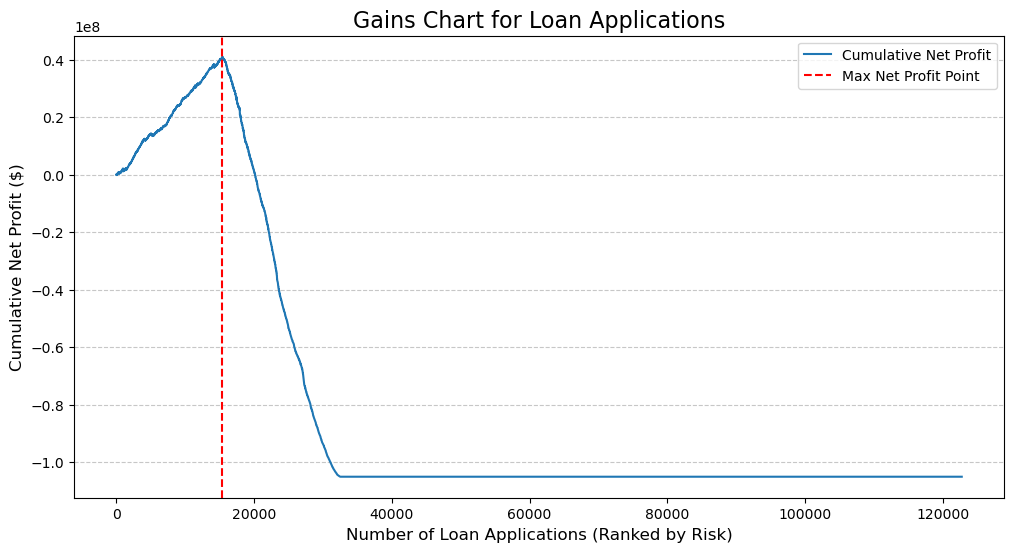

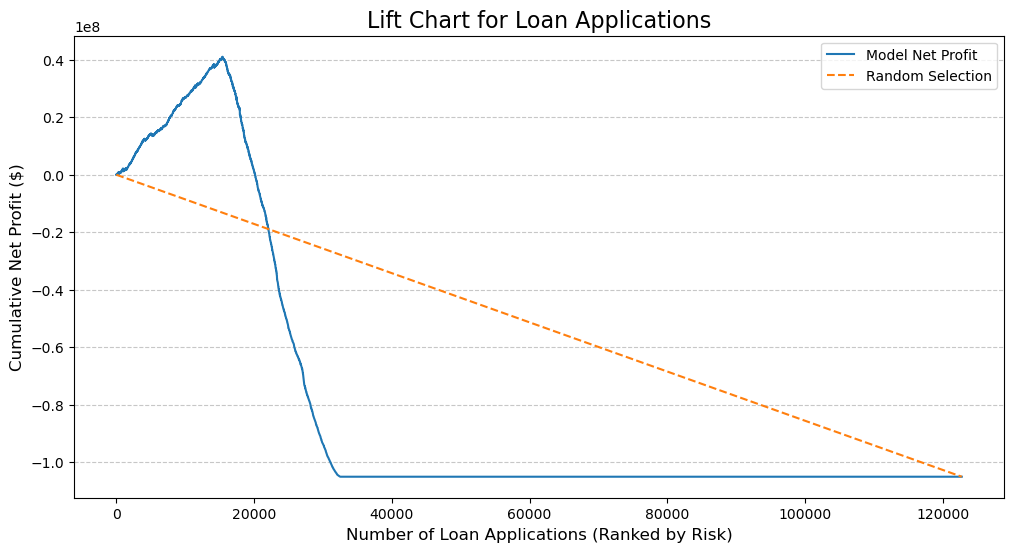

In [10]:
knn_analysis = LoanApplicationProfitAnalysis(model=knn, X_test=X_test, y_test=y_test, disbursement_test=disbursement_test)
cutoff_prob['kNN'], max_apps['kNN'], cost_matrix['kNN'], max_profits['kNN']  = knn_analysis.analyze()

In [11]:
# Calculate net profit for kNN
net_profits['kNN'] = calculate_net_profit(y_test, y_pred_knn, disbursement_test)
print(f"The Net Profit using k-Neighbors Classifier is: {net_profits['kNN']:,.2f} USD")

The Net Profit using k-Neighbors Classifier is: -49,987,428.50 USD


In [12]:
print(f"Optimal Probability Cut-Off: {cutoff_prob['kNN']:.2f}")

Optimal Probability Cut-Off: 0.96


In [13]:
print(f"Number of Applications to parse: {max_apps['kNN']}")

Number of Applications to parse: 15417


In [14]:
print(f"The Maximum Profit for optimal Number of Applications using k-Neighbors Classifier is: {max_profits['kNN']:,.2f} USD")

The Maximum Profit for optimal Number of Applications using k-Neighbors Classifier is: 41,089,180.19 USD


In [15]:
print(f"Cost Gain Matrix:\n {cost_matrix['kNN']}")

Cost Gain Matrix:
          Scenario  Count Per Loan Gain/Loss ($) Total Gain/Loss ($)
0   True Positive  17448              $9,237.29     $161,172,299.70
1  False Positive   4716            $-46,186.47    $-217,815,384.40
2   True Negative  95934                  $0.00               $0.00
3  False Negative   4647                  $0.00               $0.00


**kNN Model Insights**

1. Gain Chart Analysis
    - Trend: The cumulative net profit rises initially, peaking at approximately 15,417 approved applications, and sharply declines as lower-ranked applications (higher risk) are processed.
    - Optimal Point: The peak net profit occurs around the 15,417th application, marked by the red dashed line, indicating diminishing returns beyond this point.
2. Lift Chart Analysis
    - Model vs. Random Baseline: The model's performance significantly outperforms random selection in terms of cumulative net profit, especially for top-ranked applications. The gap narrows as more applications are processed, highlighting the model's predictive advantage for high-ranking applications.
3. Net Profit Evaluation
    - Trend: The k-Nearest Neighbors (k-NN) classifier achieves a total profit of 41,089,180.19 USD at the peak but shows losses of 49,987,428.50 USD when processing the full dataset.
    - Key Contributors: True positives drive gains, while false positives significantly reduce overall profit. Optimizing the trade-off between these metrics is crucial.
4. Optimal Probability and Loan Approval Range
    - Cutoff Probability: The optimal cutoff probability of 0.96 ensures loans with high repayment likelihoods are approved, mitigating risks from false positives.
    - Insights: Use the 0.96 threshold to guide loan approval processes, ensuring a balance between risk and reward.
5. Maximum Profit Analysis
    - Maximum Profit Point: Achieved at 15,417 applications with a net profit of 41,089,180.19 USD. Beyond this, losses from false positives outweigh gains.
    - Strategies: Limit loan processing to this point. Monitor model predictions continuously to fine-tune this threshold for evolving datasets.
6. Cost/Gain Matrix
    - True Positives (17,448): Generate significant gains (161,172,299.70 USD).
    - False Positives (4,716): Cause substantial losses (217,815,384.40 USD), indicating room for improvement in reducing false positive rates.
    
    
**Summary**
1. If we use this model, we should focus on approving loans up to 15,417 applications for maximum profit and avoid processing additional loans past this point as they result in significant financial losses.
2. The model is highly effective for prioritizing high-confidence loan approvals. We should emphasize using this model for top-performing segments to maximize profitability.

### Decision Tree Classifier

The criterion determines the impurity or disorder in the sample. The Gini criterion efficiently measures impurity without requiring logarithmic calculations, unlike entropy. This parameter was also cross-validated using RandomSearchCV.

In [16]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and fit decision tree
tree = DecisionTreeClassifier(min_samples_split=18, min_samples_leaf=7, max_depth=5, criterion='gini')
tree.fit(X_train, y_train)

# Predict and evaluate
y_pred_tree = tree.predict(X_test)
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_tree))

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    100650
           1       0.97      0.99      0.98     22095

    accuracy                           0.99    122745
   macro avg       0.99      0.99      0.99    122745
weighted avg       0.99      0.99      0.99    122745



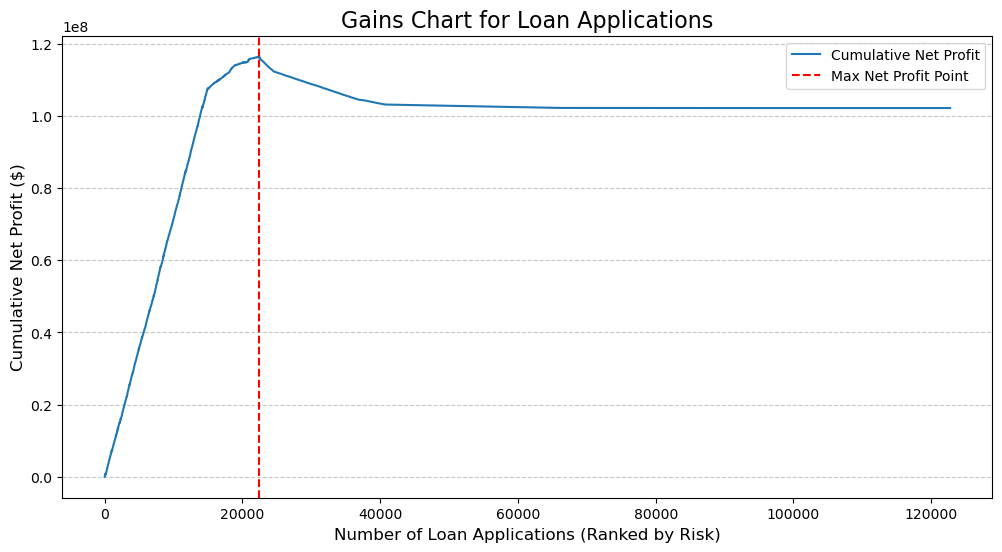

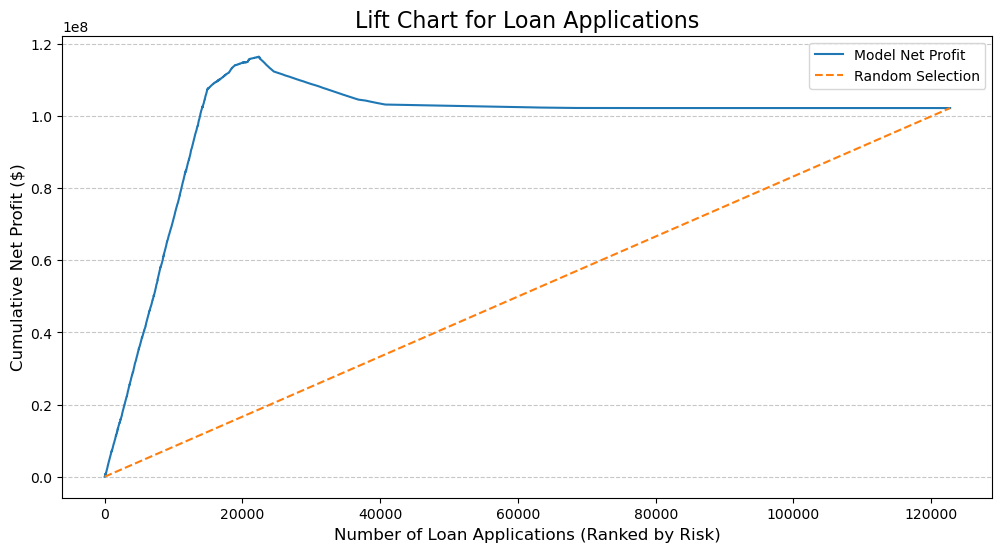

In [17]:
tree_analysis = LoanApplicationProfitAnalysis(model=tree, X_test=X_test, y_test=y_test, disbursement_test=disbursement_test)
cutoff_prob['DecisionTree'], max_apps['DecisionTree'], cost_matrix['DecisionTree'], max_profits['DecisionTree'] = tree_analysis.analyze()

In [18]:
# Calculate net profit for Decision Tree Classifier
net_profits['DecisionTree'] = calculate_net_profit(y_test, y_pred_tree, disbursement_test)
print(f"The Net Profit using Decision Tree Classifier is: {net_profits['DecisionTree']:,.2f} USD")

The Net Profit using Decision Tree Classifier is: 116,307,604.50 USD


In [19]:
print(f"Optimal Probability Cut-Off: {cutoff_prob['DecisionTree']:.2f}")

Optimal Probability Cut-Off: 0.92


In [20]:
print(f"Number of Applications to parse: {max_apps['DecisionTree']}")

Number of Applications to parse: 22334


In [21]:
print(f"The Maximum Profit for optimal Number of Applications using Decision Tree Classifier is: {max_profits['DecisionTree']:,.2f} USD")

The Maximum Profit for optimal Number of Applications using Decision Tree Classifier is: 116,418,883.68 USD


In [22]:
print(f"Cost Gain Matrix:\n {cost_matrix['DecisionTree']}")

Cost Gain Matrix:
          Scenario   Count Per Loan Gain/Loss ($) Total Gain/Loss ($)
0   True Positive   21943              $9,237.29     $202,693,934.68
1  False Positive     635            $-46,186.47     $-29,328,407.36
2   True Negative  100015                  $0.00               $0.00
3  False Negative     152                  $0.00               $0.00


**Decision Tree Model Insights**

1. Gains Chart Analysis
    - Trend: The cumulative net profit exhibits a sharp increase initially, reaching a peak at 22,334 applications, followed by a slight plateau and eventual decline.
    - Optimal Point: The red dashed line highlights the maximum net profit, achieved at 22,334 applications. Approving beyond this number yields diminishing returns.
    
2. Lift Chart Analysis
    - Model vs. Random Baseline: The model consistently outperforms random selection, especially for the top-ranked loan applications. The gap remains substantial for the majority of the chart, demonstrating the model's efficiency.
    
3. Net Profit Evaluation
    - Profit Analysis: The Decision Tree Classifier achieves a net profit of 116,307,604.50 USD, with most gains driven by true positives (202,693,934.68 USD). Losses from false positives are minimal (29,328,407.36 USD), showing strong predictive capabilities.
    - Key Contributors: The high true positive count is a significant factor in profitability, offsetting the minimal impact of false positives.
    
4. Optimal Probability and Loan Approval Range
    - Cutoff Probability: The optimal threshold of 0.92 effectively balances risk and reward, ensuring only high-probability loans are approved.
    - Loan Range: With 22,334 applications processed, the model maintains profitability without overextending into riskier segments.
    - Insights: Use the 0.92 cutoff to guide decisions and maintain high net profit levels.
    
5. Maximum Profit Analysis
    - Peak Profit: The maximum profit of 116,418,883.68 USD is achieved with 22,334 applications. The plateau following this point indicates the model’s limit in distinguishing profitable loans from high-risk ones.
    - Strategies: Stop processing beyond this point and reevaluate model thresholds for future datasets to sustain profitability.

6. Cost/Gain Matrix
    - True Positives (21,943): Major contributors to profit (202,693,934.68 USD).
    - False Positives (635): Minimal losses (29,328,407.36 USD) compared to gains.
    - Negligible impact from False Negatives (152).

**Summary**
1.  Focus on approving loans up to 22,334 applications for maximum profitability while avoiding the less profitable, higher-risk applications.
2. The decision tree model effectively prioritizes high-quality applications. Using it to guide loan approvals ensures superior profitability compared to random selection.

### Random Forest Classifier

In [23]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and fit random forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = random_forest.predict(X_test)
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    100650
           1       0.97      0.99      0.98     22095

    accuracy                           0.99    122745
   macro avg       0.98      0.99      0.99    122745
weighted avg       0.99      0.99      0.99    122745



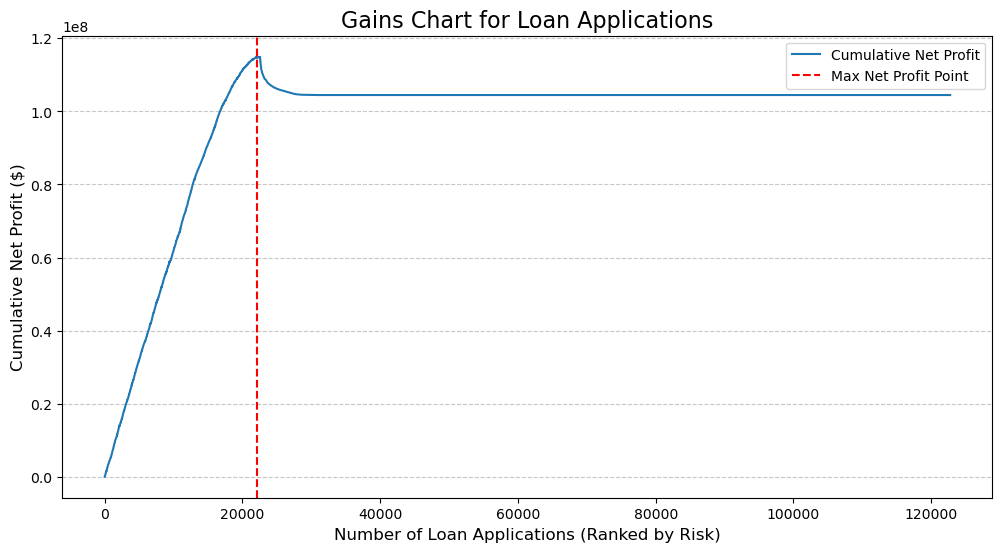

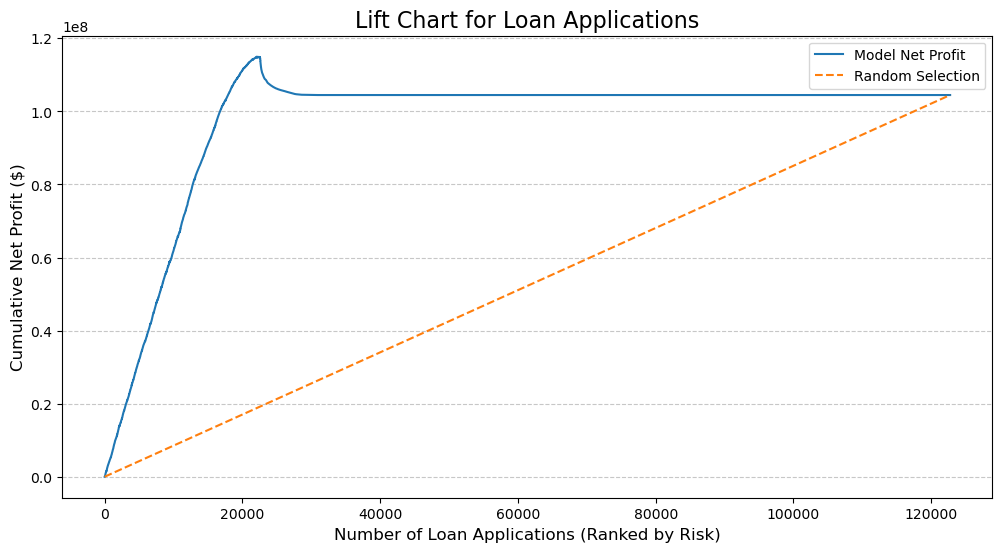

In [24]:
rf_analysis = LoanApplicationProfitAnalysis(model=random_forest, X_test=X_test, y_test=y_test, disbursement_test=disbursement_test)
cutoff_prob['RandomForest'], max_apps['RandomForest'], cost_matrix['RandomForest'], max_profits['RandomForest'] = rf_analysis.analyze()

In [25]:
# Calculate net profit for Random Forest Classifier
net_profits['RandomForest'] = calculate_net_profit(y_test, y_pred_rf, disbursement_test)
print(f"The Net Profit using Random Forest Classifier is: {net_profits['RandomForest']:,.2f} USD")

The Net Profit using Random Forest Classifier is: 113,016,941.00 USD


In [26]:
print(f"Optimal Probability Cut-Off: {cutoff_prob['RandomForest']:.2f}")

Optimal Probability Cut-Off: 0.86


In [27]:
print(f"Number of Applications to parse: {max_apps['RandomForest']}")

Number of Applications to parse: 22129


In [28]:
print(f"The Maximum Profit for optimal Number of Applications using Random Forest Classifier is: {max_profits['RandomForest']:,.2f} USD")

The Maximum Profit for optimal Number of Applications using Random Forest Classifier is: 114,977,428.92 USD


In [29]:
print(f"Cost Gain Matrix:\n {cost_matrix['RandomForest']}")

Cost Gain Matrix:
          Scenario  Count Per Loan Gain/Loss ($) Total Gain/Loss ($)
0   True Positive  21938              $9,237.29     $202,647,748.22
1  False Positive    687            $-46,186.47     $-31,730,103.71
2   True Negative  99963                  $0.00               $0.00
3  False Negative    157                  $0.00               $0.00


**Random Forest Model Insights**

1. Gains Chart Analysis
    - Trend: The cumulative net profit increases sharply up to 22,129 applications, where it peaks at approximately 114,977,428.92 USD. Beyond this, it plateaus, indicating that additional applications contribute minimal or no profit.
    - Optimal Point: The red dashed line at 22,129 applications marks the maximum profitability point.
    
2. Lift Chart Analysis
    - Model vs. Random Baseline: The Random Forest model significantly outperforms the random selection baseline, especially for top-ranked applications. The gap narrows as more applications are processed, highlighting the model's strength in prioritizing high-quality loans.
    
3. Net Profit Evaluation
    - Profit Analysis: The model achieves a total net profit of 113,016,941.00 USD. The majority of gains stem from true positives (202,647,748.22 USD), with losses from false positives being relatively low (31,730,103.71 USD).
    - Key Contributors: Accurate classification of true positives drives profitability, while false positives have a manageable impact.

4. Optimal Probability and Loan Approval Range
    - Cutoff Probability: The optimal threshold of 0.86 balances precision and recall, ensuring most high-repayment loans are approved while limiting risk.
    - Loan Range: Approving the top 22,129 ranked applications maximizes profit while avoiding unnecessary risks.
    - Insights: Implement this threshold in loan approval processes for optimal performance.
    
5. Maximum Profit Analysis
    - Peak Profit: The maximum cumulative profit of 114,977,428.92 USD occurs at 22,129 applications. The plateau beyond this point suggests limited returns for further approvals.
    - Strategies: Restrict loan processing to this range and continuously refine the model to sustain high profits over time.
    
6. Cost/Gain Matrix
    - True Positives (21,938): Generate significant gains (202,647,748.22 USD).
    - False Positives (687): Cause relatively small losses (31,730,103.71 USD).
    - Minimal False Negatives (157): Low impact on profitability.
    
**Summary**
1. Approve loans up to 22,129 applications and avoid processing lower-ranked applications, which offer diminishing returns.
2. The model provides superior profit optimization for the top-ranked loans. Rely on the model for these decisions to maximize gains.

### Bagging Classifier

We want our model to be robust. Therefore, we set bootstrap=False to ensure that weak estimators are not reused during model training. The values for n_estimators and max_depth were cross-validated using Random Search.

In [30]:
from sklearn.ensemble import BaggingClassifier

# Initialize and fit bagging classifier
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5), random_state=42, n_estimators=10, bootstrap=False)
bagging.fit(X_train, y_train)

# Predict and evaluate
y_pred_bagging = bagging.predict(X_test)
print("Bagging Classification Report:\n", classification_report(y_test, y_pred_bagging))

Bagging Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    100650
           1       0.97      0.99      0.98     22095

    accuracy                           0.99    122745
   macro avg       0.99      0.99      0.99    122745
weighted avg       0.99      0.99      0.99    122745



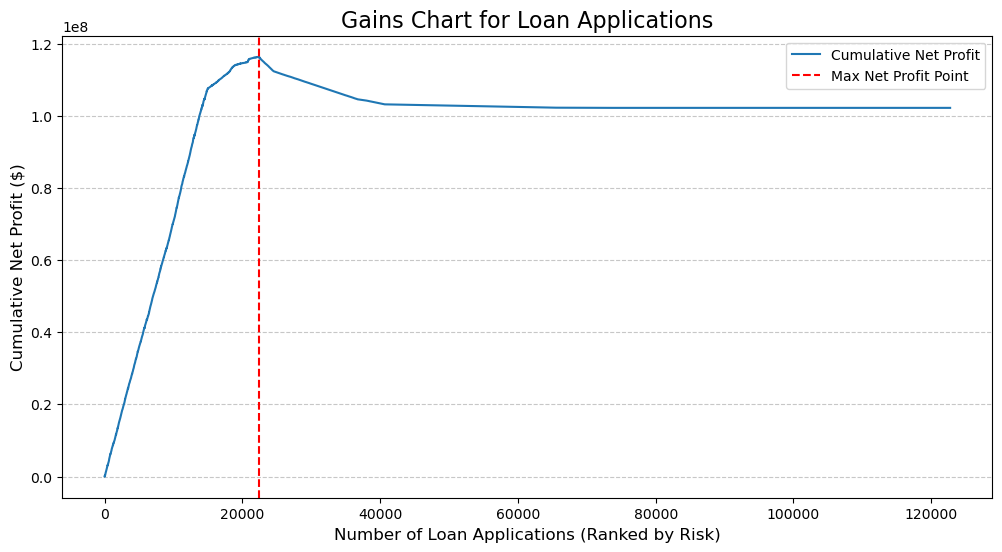

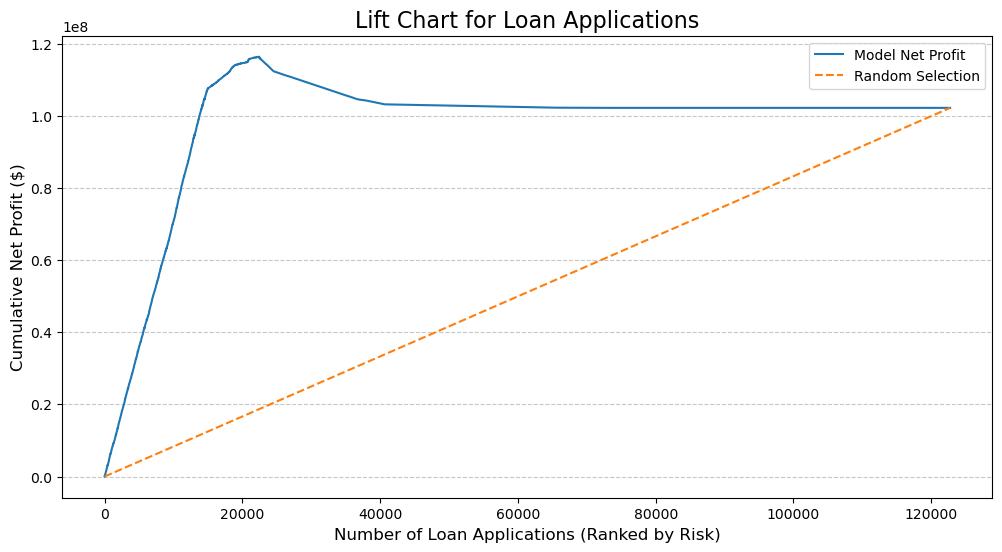

In [31]:
bagging_analysis = LoanApplicationProfitAnalysis(model=bagging, X_test=X_test, y_test=y_test, disbursement_test=disbursement_test)
cutoff_prob['Bagging'], max_apps['Bagging'], cost_matrix['Bagging'], max_profits['Bagging'] = bagging_analysis.analyze()

In [32]:
# Calculate net profit for Bagging Classifier
net_profits['Bagging'] = calculate_net_profit(y_test, y_pred_bagging, disbursement_test)
print(f"The Net Profit using Bagging Classifier is: {net_profits['Bagging']:,.2f} USD")

The Net Profit using Bagging Classifier is: 116,307,604.50 USD


In [33]:
print(f"Optimal Probability Cut-Off: {cutoff_prob['Bagging']:.2f}")

Optimal Probability Cut-Off: 0.89


In [34]:
print(f"Number of Applications to parse: {max_apps['Bagging']}")

Number of Applications to parse: 22378


In [35]:
print(f"The Maximum Profit for optimal Number of Applications using Bagging Classifier is: {max_profits['Bagging']:,.2f} USD")

The Maximum Profit for optimal Number of Applications using Bagging Classifier is: 116,392,540.50 USD


In [36]:
print(f"Cost Gain Matrix:\n {cost_matrix['Bagging']}")

Cost Gain Matrix:
          Scenario   Count Per Loan Gain/Loss ($) Total Gain/Loss ($)
0   True Positive   21943              $9,237.29     $202,693,934.68
1  False Positive     636            $-46,186.47     $-29,374,593.82
2   True Negative  100014                  $0.00               $0.00
3  False Negative     152                  $0.00               $0.00


**Bagging Classifier Model Insights**

1. Gains Chart Analysis
    - Trend: The cumulative net profit rises sharply up to 22,378 applications, where it peaks at approximately 116,392,540.50 USD. Beyond this, the curve flattens, indicating minimal gains from additional applications.
    - Optimal Point: The red dashed line marks the optimal point at 22,378 applications.
    
2. Lift Chart Analysis
    - Model vs. Random Baseline: The Bagging Classifier significantly outperforms random selection, particularly in the initial applications. The model's curve plateaus, maintaining an advantage over random selection throughout the range.
    
3. Net Profit Evaluation
    - Profit Analysis: The Bagging Classifier achieves a total net profit of 116,307,604.50 USD. Gains from true positives (202,693,934.68 USD) significantly outweigh the relatively low losses from false positives (29,374,593.82 USD).
    - Key Contributors: High precision in identifying true positives drives profitability, while losses due to false positives remain minimal.
    
4. Optimal Probability and Loan Approval Range
    - Cutoff Probability: The optimal threshold of 0.89 strikes a balance between precision and recall, effectively filtering high-risk loans.
    - Loan Range: Approving up to 22,378 applications ensures optimal profit while minimizing unnecessary risks.
    - Insights: Utilize the 0.89 threshold to enhance decision-making and maximize profitability.
    
5. Maximum Profit Analysis
    - Peak Profit: The maximum profit of 116,392,540.50 USD is achieved at 22,378 applications, beyond which the incremental benefit is negligible.
    - Strategies: Restrict loan approvals to this range and periodically evaluate the model’s performance to adjust thresholds as needed.

6. Cost/Gain Matrix Analysis
    - True Positives (21,943): Contribute significant gains (202,693,934.68 USD).
    - False Positives (636): Result in moderate losses (29,374,593.82 USD).
    - False Negatives (152): Negligible impact on profitability.
    
**Summary**
1. Loan approvals should be restricted to 22,378 applications to maximize profitability while avoiding diminishing returns.
2. The model effectively prioritizes high-quality loans. Leveraging it for the top-ranked applications ensures maximum gains.

### Gradient Boosting Classifier

1. The number of estimators defines the number of trees in the model, and this value is arbitrary, varying depending on the problem. 
2. To determine the optimal value, we implemented Random Search, which identified 100 as the best number of trees. 
3. The maximum depth defines the depth of the tree and indicates the number of layers in the model. This value is also arbitrary and was cross-validated using RandomSearchCV.
4. The minimum child weight (which represents the minimum samples required for a leaf node) determines whether a node will split or become a leaf. This value depends on the number of input features and was cross-validated using Random Search. 
5. The learning rate was also cross-validated by running random search in the range of 0.001 to 0.1. This acts as the gradient boost for this.

In [37]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize and fit boosting classifier
boosting = GradientBoostingClassifier(n_estimators=100, max_depth=4, learning_rate=0.02, random_state=42)
boosting.fit(X_train, y_train)

# Predict and evaluate
y_pred_boosting = boosting.predict(X_test)
print("Boosting Classification Report:\n", classification_report(y_test, y_pred_boosting))

Boosting Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    100650
           1       0.97      0.99      0.98     22095

    accuracy                           0.99    122745
   macro avg       0.99      0.99      0.99    122745
weighted avg       0.99      0.99      0.99    122745



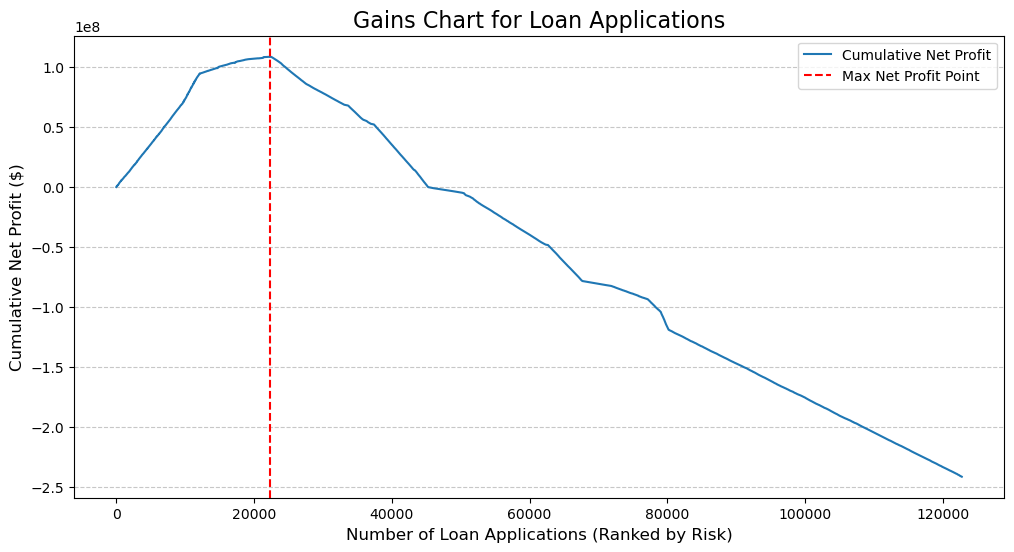

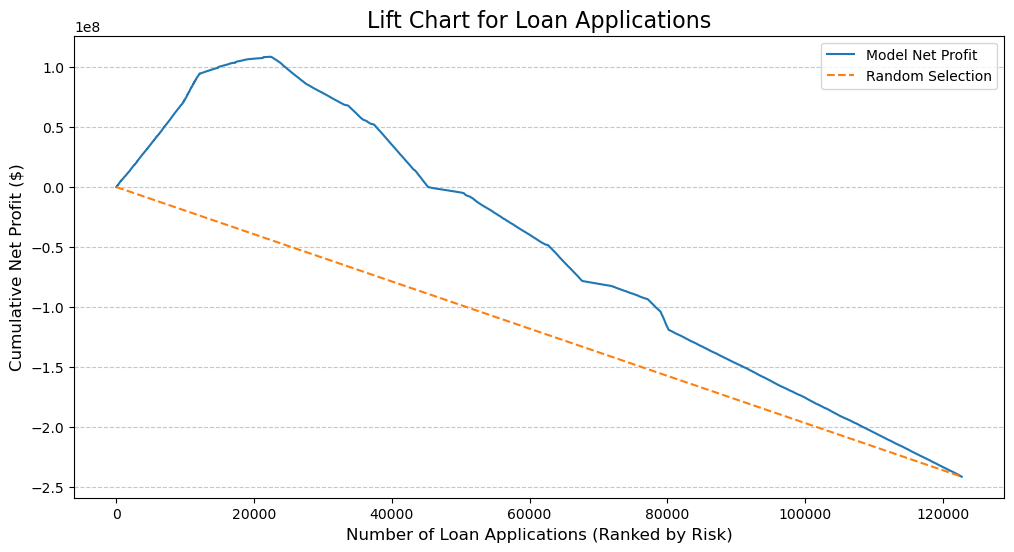

In [38]:
boosting_analysis = LoanApplicationProfitAnalysis(model=boosting, X_test=X_test, y_test=y_test, disbursement_test=disbursement_test)
cutoff_prob['Boosting'], max_apps['Boosting'], cost_matrix['Boosting'], max_profits['Boosting'] = boosting_analysis.analyze()

In [39]:
# Calculate net profit for Gradient Boosting Classifier
net_profits['Boosting'] = calculate_net_profit(y_test, y_pred_boosting, disbursement_test)
print(f"The Net Profit using Gradient Boosting Classifier is: {net_profits['Boosting']:,.2f} USD")

The Net Profit using Gradient Boosting Classifier is: 116,307,604.50 USD


In [40]:
print(f"Optimal Probability Cut-Off: {cutoff_prob['Boosting']:.2f}")

Optimal Probability Cut-Off: 0.88


In [41]:
print(f"Number of Applications to parse: {max_apps['Boosting']}")

Number of Applications to parse: 22307


In [42]:
print(f"The Maximum Profit for optimal Number of Applications using Gradient Boosting Classifier is: {max_profits['Boosting']:,.2f} USD")

The Maximum Profit for optimal Number of Applications using Gradient Boosting Classifier is: 108,548,295.17 USD


In [43]:
print(f"Cost Gain Matrix:\n {cost_matrix['Boosting']}")

Cost Gain Matrix:
          Scenario   Count Per Loan Gain/Loss ($) Total Gain/Loss ($)
0   True Positive   21943              $9,237.29     $202,693,934.68
1  False Positive     635            $-46,186.47     $-29,328,407.36
2   True Negative  100015                  $0.00               $0.00
3  False Negative     152                  $0.00               $0.00


**Gradient Boosting Model Insights**

1. Gains Chart Analysis
    - Trend: The cumulative net profit increases sharply and peaks at approximately 22,307 applications, where it reaches 108,548,295.17 USD. Beyond this point, the profit declines steeply, with significant losses as more low-ranked applications are processed.
    - Optimal Point: The red dashed line marks the maximum profitability point at 22,307 applications.
    
2. Lift Chart Analysis
    - Model vs. Random Baseline: The Gradient Boosting model significantly outperforms random selection, particularly in the top-ranked loans. However, as more applications are processed, the model's advantage decreases, and profits turn negative for low-ranked loans.
    
3. Net Profit Evaluation
    - Profit Analysis: The Gradient Boosting model achieves a total net profit of 108,548,295.17 USD at its peak. Gains are primarily driven by true positives (202,693,934.68 USD), with relatively low losses from false positives (29,328,407.36 USD).
    - Key Contributors: High precision in predicting true positives ensures profitability, while false positives have a limited impact due to their low numbers.
    
4. Optimal Probability and Loan Approval Range
    - Cutoff Probability: The optimal threshold of 0.88 ensures the model focuses on high-repayment loans, minimizing risks associated with false positives.
    - Loan Range: Approving up to 22,307 applications ensures maximum profit while avoiding the riskier segments.
    - Insights: Use the 0.88 cutoff for effective decision-making and profitability optimization.
    
5. Maximum Profit Analysis
    - Peak Profit: The maximum profit of 108,548,295.17 USD is achieved at 22,307 applications. Beyond this, losses from false positives and low repayment rates outweigh gains.
    - Strategies: Limit loan approvals to this range and periodically reevaluate thresholds and model parameters for sustained performance.
    
6. Cost/Gain Matrix 
    - True Positives (21,943): Generate significant gains (202,693,934.68 USD).
    - False Positives (635): Result in manageable losses (29,328,407.36 USD).
    - Negligible impact from False Negatives (152).
    
**Summary**
1. Approving loans beyond 22,307 applications leads to diminishing returns and eventually negative profitability. Limit approvals to maintain profitability.
2. The model is highly effective in the top segment but loses its predictive advantage with lower-ranked applications. Focus loan approvals on the higher-ranked segment.

### eXtream Gradient Boosting Classifier (XGBoost)

1. The number of estimators defines the number of trees in the model, and this value is arbitrary, varying depending on the problem. 
2. To determine the optimal value, we implemented Random Search, which identified 100 as the best number of trees. 
3. The maximum depth defines the depth of the tree and indicates the number of layers in the model. This value is also arbitrary and was cross-validated using RandomSearchCV.
4. The minimum child weight (which represents the minimum samples required for a leaf node) determines whether a node will split or become a leaf. This value depends on the number of input features and was cross-validated using Random Search. 
5. The learning rate was also cross-validated by running random search in the range of 0.001 to 0.1. This acts as the gradient boost for this.

In [44]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# Initialize XGBoost Classifier with parameters
xgb_model = xgb.XGBClassifier(
    n_estimators=100,        # Number of trees
    max_depth=4,             # Maximum tree depth
    learning_rate=0.02,      # Learning rate (similar to Gradient Boosting)
    min_child_weight=2,      # Equivalent to min_samples_leaf
    subsample=1.0,           # Use all samples
    colsample_bytree=1.0,    # Use all features
    objective='binary:logistic',  # Objective for binary classification
    random_state=42          # For reproducibility
)

# Perform cross-validation to evaluate performance
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')

# Train the model on the training set
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgboost = xgb_model.predict(X_test)
print("Extream Boosting Classification Report:\n", classification_report(y_test, y_pred_xgboost))

Extream Boosting Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    100650
           1       0.97      0.99      0.98     22095

    accuracy                           0.99    122745
   macro avg       0.99      0.99      0.99    122745
weighted avg       0.99      0.99      0.99    122745



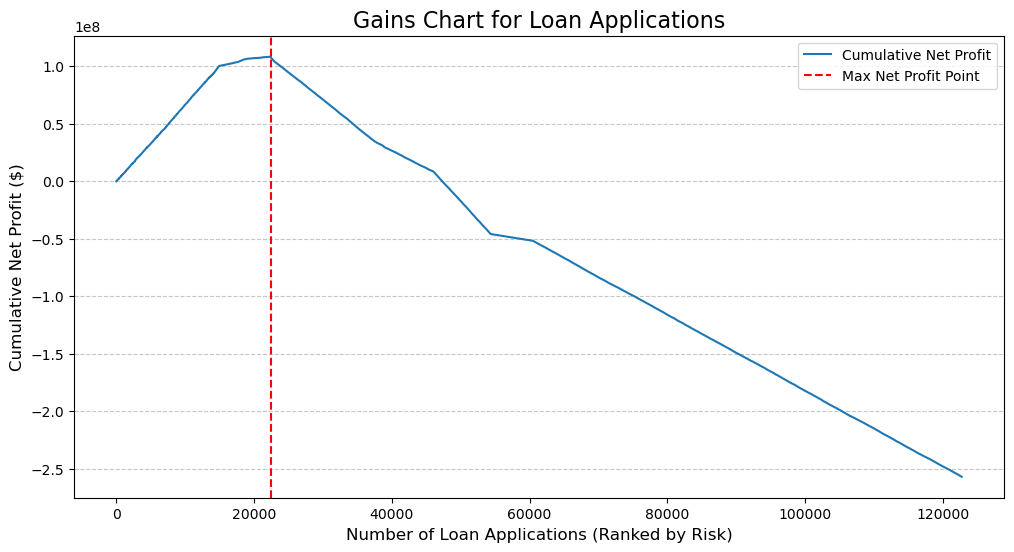

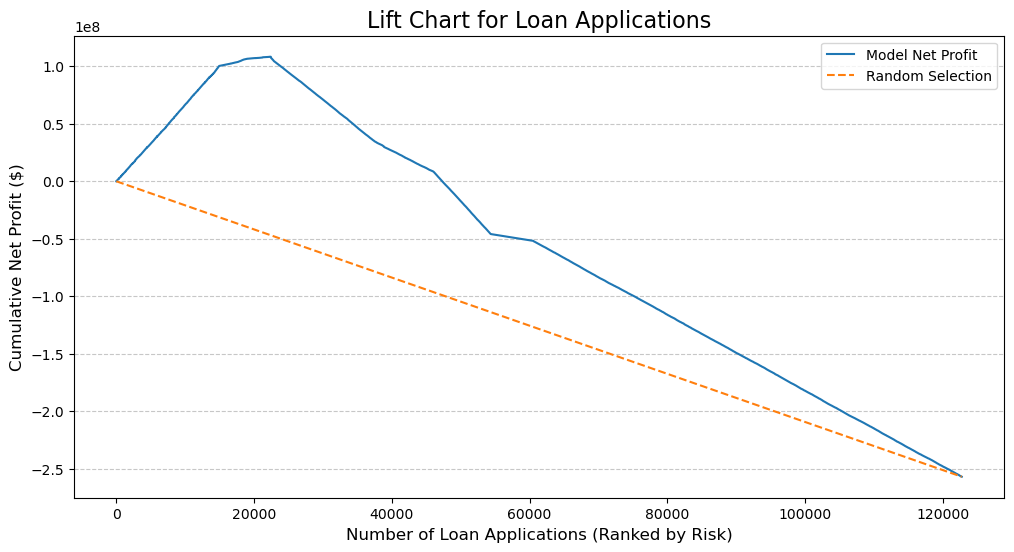

In [45]:
xgb_analysis = LoanApplicationProfitAnalysis(model=xgb_model, X_test=X_test, y_test=y_test, disbursement_test=disbursement_test)
cutoff_prob['XGBoosting'], max_apps['XGBoosting'], cost_matrix['XGBoosting'], max_profits['XGBoosting'] = xgb_analysis.analyze()

In [46]:
# Calculate net profit for Gradient Boosting Classifier
net_profits['XGBoosting'] = calculate_net_profit(y_test, y_pred_xgboost, disbursement_test)
print(f"The Net Profit using Extreme Gradient Boosting Classifier is: {net_profits['XGBoosting']:,.2f} USD")

The Net Profit using Extreme Gradient Boosting Classifier is: 116,372,293.10 USD


In [47]:
print(f"Optimal Probability Cut-Off: {cutoff_prob['XGBoosting']:.2f}")

Optimal Probability Cut-Off: 0.87


In [48]:
print(f"Number of Applications to parse: {max_apps['XGBoosting']}")

Number of Applications to parse: 22402


In [49]:
print(f"The Maximum Profit for optimal Number of Applications using Extream Boosting Classifier is: {max_profits['XGBoosting']:,.2f} USD")

The Maximum Profit for optimal Number of Applications using Extream Boosting Classifier is: 108,273,825.69 USD


In [50]:
print(f"Cost Gain Matrix:\n {cost_matrix['XGBoosting']}")

Cost Gain Matrix:
          Scenario   Count Per Loan Gain/Loss ($) Total Gain/Loss ($)
0   True Positive   21828              $9,237.29     $201,631,645.91
1  False Positive     601            $-46,186.47     $-27,758,067.43
2   True Negative  100049                  $0.00               $0.00
3  False Negative     267                  $0.00               $0.00


**XG Boosting Model Analysis**
1. Gains Chart Analysis
    - Trend: The cumulative net profit shows a sharp rise initially, peaking at 22,402 applications, followed by a    plateau and eventual decline.
    - Optimal Point: The red dashed line indicates the maximum net profit, achieved at 22,402 applications. Approving beyond this number results in diminishing returns.

2. Lift Chart Analysis
    - Model vs. Random Baseline: The XGBoost model consistently outperforms random selection, especially for top-ranked loan applications. The gap remains substantial for most of the chart, demonstrating the model's efficiency.
   
3. Net Profit Evaluation
   - Profit Analysis: The XGBoost model achieves a net profit of 116,372,293.10 USD, with most gains driven by true positives (201,631,645.91 USD). Losses from false positives are minimal (27,758,067.43 USD), showcasing strong    predictive capabilities.
   - Key Contributors: The high true positive count is the primary driver of profitability, offsetting the limited impact of false positives.
   
4. Optimal Probability and Loan Approval Range
    - Cutoff Probability: The optimal threshold of 0.87 balances risk and reward effectively, ensuring only high-probability loans are approved.
    - Loan Range: With 22,402 applications processed, the model maintains profitability without overextending into riskier segments.
    - Insights: Use the 0.87 cutoff to guide decisions and sustain high profitability levels.

5. Maximum Profit Analysis   
    - Peak Profit: The maximum profit of 108,273,825.69 USD is achieved with 22,402 applications. The plateau beyond this point indicates the model's limit in distinguishing profitable loans from high-risk ones.
    - Strategies: Stop processing beyond this point and reevaluate model thresholds for future datasets to sustain profitability.

6. Cost/Gain Matrix    
    - True Positives (21,828): Major contributors to profit (201,631,645.91 USD).
    - False Positives (601): Minimal losses (27,758,067.43 USD) compared to gains.
    - False Negatives (267) and True Negatives (100,049): Negligible impact on profitability.

**Summary**
1. Focus on approving loans up to 22,402 applications for maximum profitability while avoiding less-profitable, higher-risk applications.
2. The 0.87 cutoff probability ensures superior profitability by effectively prioritizing high-quality applications.

### Logistic Regression (Ridge)

We used the LBFGS solver (Limited-memory Broyden–Fletcher–Goldfarb–Shanno), an optimization algorithm that minimizes the objective function based on the gradient. LBFGS also uses less computer memory, as it keeps removing the values of the gradient as it keeps decreasing. This choice was also cross-validated using grid search. This is also the best performing Logistic Regression model.

In [51]:
from sklearn.linear_model import LogisticRegressionCV

# Initialize and fit logistic regression
ridge = LogisticRegressionCV(random_state=42, max_iter=1000, penalty='l2', solver='lbfgs', cv=5)
ridge.fit(X_train, y_train)

# Predict and evaluate
y_pred_ridge = ridge.predict(X_test)
print("Logistic Regression(Ridge) Classification Report:\n", classification_report(y_test, y_pred_ridge))

Logistic Regression(Ridge) Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    100650
           1       0.98      0.95      0.97     22095

    accuracy                           0.99    122745
   macro avg       0.98      0.97      0.98    122745
weighted avg       0.99      0.99      0.99    122745



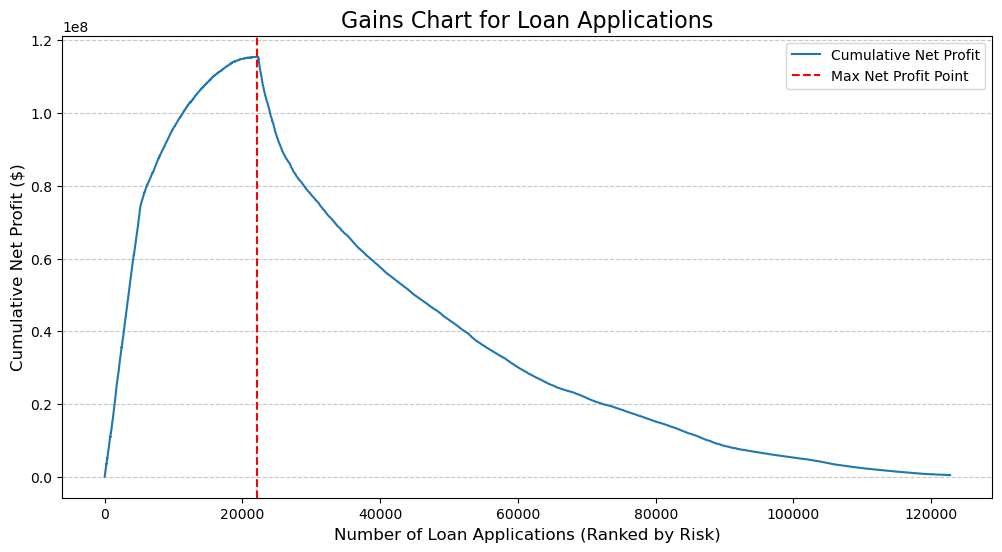

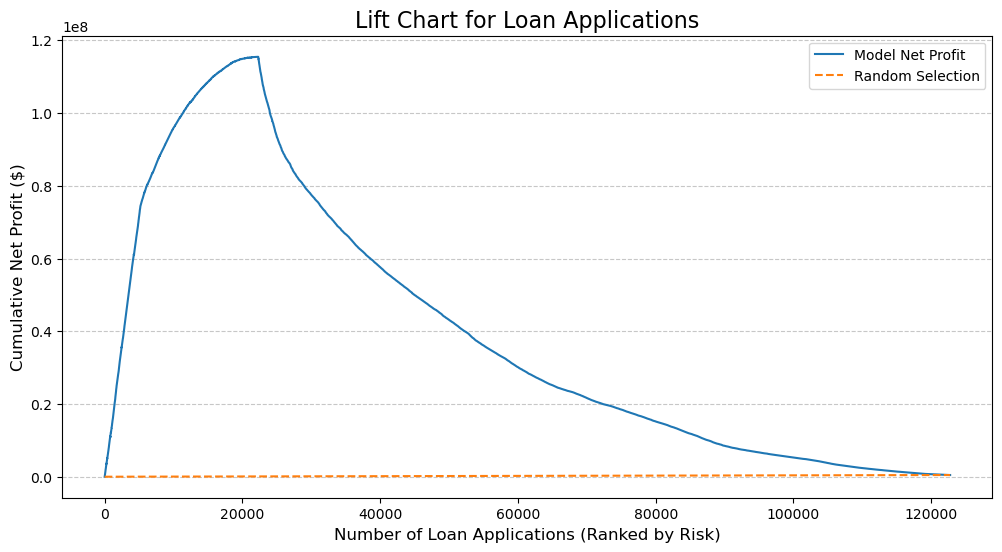

In [52]:
ridge_analysis = LoanApplicationProfitAnalysis(model=ridge, X_test=X_test, y_test=y_test, disbursement_test=disbursement_test)
cutoff_prob['RidgeLogistic'], max_apps['RidgeLogistic'], cost_matrix['RidgeLogistic'], max_profits['RidgeLogistic'] = ridge_analysis.analyze()

In [53]:
# Calculate net profit for Gradient Boosting Classifier
net_profits['RidgeLogistic'] = calculate_net_profit(y_test, y_pred_ridge, disbursement_test)
print(f"The Net Profit using Ridge Logistic Regression is: {net_profits['RidgeLogistic']:,.2f} USD")

The Net Profit using Ridge Logistic Regression is: 115,629,050.45 USD


In [54]:
print(f"Optimal Probability Cut-Off: {cutoff_prob['RidgeLogistic']:.2f}")

Optimal Probability Cut-Off: 0.33


In [55]:
print(f"Number of Applications to parse: {max_apps['RidgeLogistic']}")

Number of Applications to parse: 22120


In [56]:
print(f"The Maximum Profit for optimal Number of Applications using Ridge Logistic Regression is: {max_profits['RidgeLogistic']:,.2f} USD")

The Maximum Profit for optimal Number of Applications using Ridge Logistic Regression is: 115,483,600.28 USD


In [57]:
print(f"Cost Gain Matrix:\n {cost_matrix['RidgeLogistic']}")

Cost Gain Matrix:
          Scenario   Count Per Loan Gain/Loss ($) Total Gain/Loss ($)
0   True Positive   21087              $9,237.29     $194,786,811.31
1  False Positive     521            $-46,186.47     $-24,063,149.97
2   True Negative  100129                  $0.00               $0.00
3  False Negative    1008                  $0.00               $0.00


**Ridge Logistic Model Analysis**

1. Gains Chart Analysis
    - Trend: The cumulative net profit rises significantly early on, reaching a peak at 22,120 loan applications, followed by a plateau and eventual decline.
    - Optimal Point: The red dashed line highlights the maximum net profit, achieved at 22,120 applications. Approving beyond this number leads to diminishing returns.

2. Lift Chart Analysis
    - Model vs. Random Baseline: The Ridge Logistic Regression model consistently outperforms random selection, especially for top-ranked loan applications. The gap demonstrates the model's effectiveness in identifying profitable loans.

3. Net Profit Evaluation
    - Profit Analysis: The Ridge Logistic Regression model achieves a net profit of 115,629,050.45 USD, driven primarily by true positives (194,786,811.31 USD). Losses from false positives are minimal (24,063,149.97 USD), showcasing strong predictive capabilities.
    - Key Contributors: High true positive count significantly boosts profitability, offsetting the limited impact of false positives.

4. Optimal Probability and Loan Approval Range
    - Cutoff Probability: The optimal threshold of 0.33 balances risk and reward effectively, ensuring only high-confidence applications are approved.
    - Loan Range: With 22,120 applications, the model sustains profitability while avoiding riskier segments.
    - Insights: Employing the 0.33 cutoff probability optimizes decision-making and ensures profitability.

5. Maximum Profit Analysis
    - Peak Profit: The maximum profit of 115,483,600.28 USD is achieved with 22,120 applications. Profitability plateaus beyond this point, signaling the limit of profitable approvals.
    - Strategies: Stop approving beyond this range and reevaluate thresholds for future datasets to sustain profitability.

6. Cost/Gain Matrix
    - True Positives (21,087): Major contributors to profit (194,786,811.31 USD).
    - False Positives (521): Minimal losses (24,063,149.97 USD) compared to gains.
    - False Negatives (1,008) and True Negatives (100,129): Negligible impact on overall profitability.

**Summary**
1. Focus on approving loans up to 22,120 applications to maximize profitability while avoiding less-profitable, higher-risk applications.
2. Use the 0.33 cutoff probability for high-confidence approvals to maintain superior profitability levels.

### Logistic Regression (Lasso)

We used the Stochastic Average Gradient (SAG) solver, an iterative optimization solver that leverages the gradient curve for optimization. This choice was also cross-validated using grid search.

In [58]:
from sklearn.linear_model import LogisticRegressionCV

# Initialize and fit logistic regression
lasso = LogisticRegressionCV(random_state=42, max_iter=100, penalty='l1', solver='saga', cv=5)
lasso.fit(X_train, y_train)

# Predict and evaluate
y_pred_lasso = lasso.predict(X_test)
print("Logistic Regression(Lasso) Classification Report:\n", classification_report(y_test, y_pred_lasso))

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression(Lasso) Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99    100650
           1       0.97      0.93      0.95     22095

    accuracy                           0.98    122745
   macro avg       0.98      0.96      0.97    122745
weighted avg       0.98      0.98      0.98    122745



/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


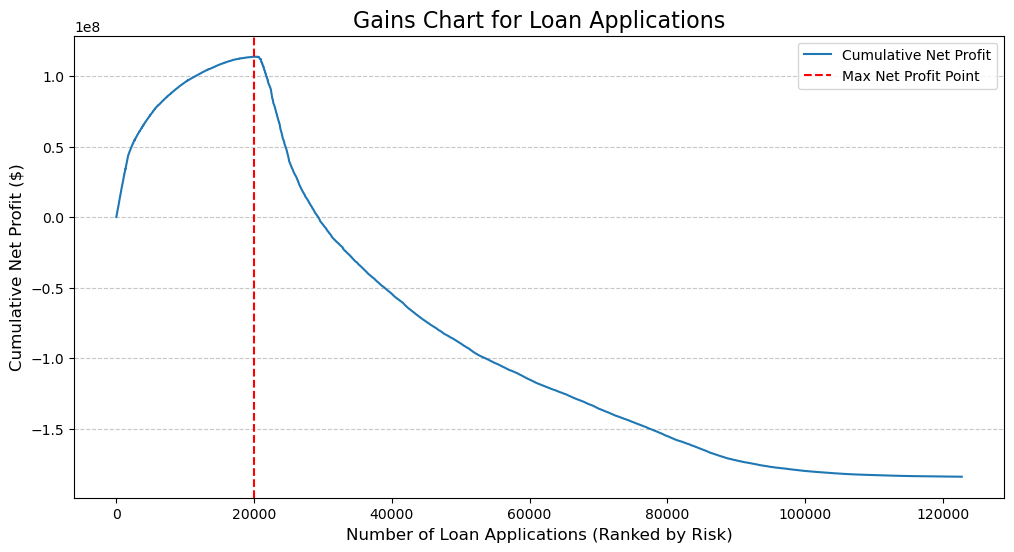

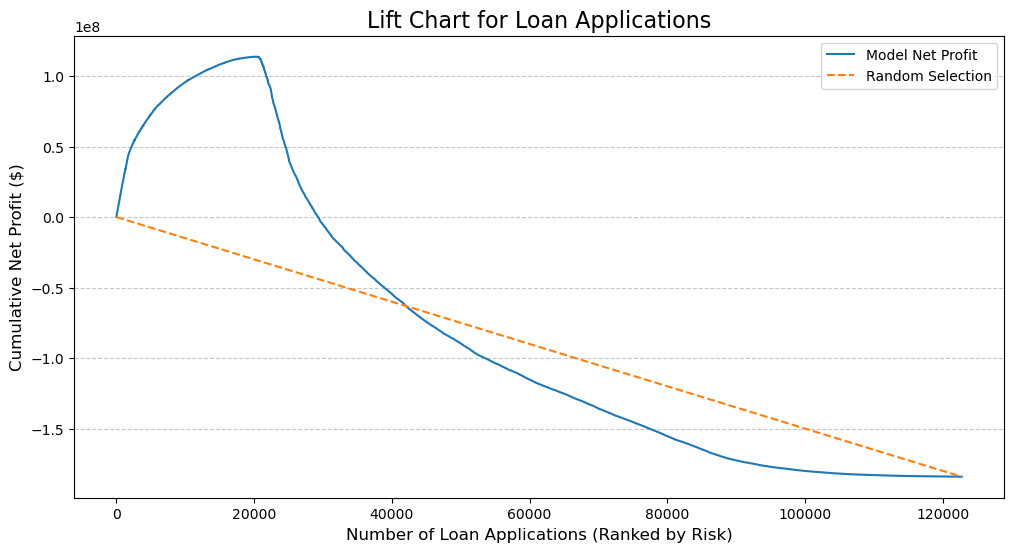

In [59]:
lasso_analysis = LoanApplicationProfitAnalysis(model=lasso, X_test=X_test, y_test=y_test, disbursement_test=disbursement_test)
cutoff_prob['LassoLogistic'], max_apps['LassoLogistic'], cost_matrix['LassoLogistic'], max_profits['LassoLogistic'] = lasso_analysis.analyze()

In [60]:
# Calculate net profit for Gradient Boosting Classifier
net_profits['LassoLogistic'] = calculate_net_profit(y_test, y_pred_lasso, disbursement_test)
print(f"The Net Profit using Lasso Logistic Regression is: {net_profits['LassoLogistic']:,.2f} USD")

The Net Profit using Lasso Logistic Regression is: 105,470,272.90 USD


In [61]:
print(f"Optimal Probability Cut-Off: {cutoff_prob['LassoLogistic']:.2f}")

Optimal Probability Cut-Off: 0.64


In [62]:
print(f"Number of Applications to parse: {max_apps['LassoLogistic']}")

Number of Applications to parse: 20030


In [63]:
print(f"The Maximum Profit for optimal Number of Applications using Lasso Logistic Regression is: {max_profits['LassoLogistic']:,.2f} USD")

The Maximum Profit for optimal Number of Applications using Lasso Logistic Regression is: 113,707,552.73 USD


In [64]:
print(f"Cost Gain Matrix:\n {cost_matrix['LassoLogistic']}")

Cost Gain Matrix:
          Scenario   Count Per Loan Gain/Loss ($) Total Gain/Loss ($)
0   True Positive   20551              $9,237.29     $189,835,621.92
1  False Positive     616            $-46,186.47     $-28,450,864.46
2   True Negative  100034                  $0.00               $0.00
3  False Negative    1544                  $0.00               $0.00


**Lasso Logistic Model Analysis**

1. Gains Chart Analysis
    - Trend: The cumulative net profit rises sharply, peaking at 20,030 loan applications, followed by a plateau and eventual decline.
    - Optimal Point: The red dashed line highlights the maximum net profit at 20,030 applications. Approving beyond this number leads to diminishing returns.

2. Lift Chart Analysis
    - Model vs. Random Baseline: The Lasso Logistic Regression model significantly outperforms random selection, especially for high-ranking loan applications. The gap showcases the model’s capability to prioritize profitable loans.

3. Net Profit Evaluation
    - Profit Analysis: The model achieves a net profit of 105,470,272.90 USD, primarily driven by true positives (189,835,621.92 USD). Losses from false positives are relatively small (28,456,864.46 USD), demonstrating efficient prediction.
    - Key Contributors: True positives contribute the majority of gains, with minimal impact from false positives.

4. Optimal Probability and Loan Approval Range
    - Cutoff Probability: The optimal probability threshold of 0.64 effectively balances risk and reward, ensuring approvals focus on high-confidence applications.
    - Loan Range: Approving 20,030 applications maintains maximum profitability without extending into riskier segments.
    - Insights: Using a cutoff of 0.64 ensures profitability while minimizing losses.

5. Maximum Profit Analysis
    - Peak Profit: The maximum profit of 113,707,552.73 USD is achieved with 20,030 applications. Beyond this, the profitability starts to decline, signaling an optimal approval limit.
    - Strategies: Stop approvals beyond this point and recalibrate thresholds for future datasets to sustain profitability.

6. Cost/Gain Matrix
    - True Positives (20,551): Major contributors to profit (189,835,621.92 USD).
    - False Positives (616): Contribute to minimal losses (28,456,864.46 USD) compared to gains.
    - False Negatives (1,544) and True Negatives (100,034): Negligible impact on overall profitability.

**Summary**
1. Focus on approving loans up to 20,030 applications for maximum profitability while avoiding less-profitable, higher-risk loans.
2. Leverage the 0.64 cutoff probability for efficient decision-making to maintain high profitability.

### Logistic Regression (ElasticNet)

ElasticNet combines both L1 and L2 penalties. In this context, the SAGA solver performed better, as cross-validated by GridSearchCV; however, the model's performance was not as good as when using L2 regularization alone.

In [65]:
from sklearn.linear_model import LogisticRegressionCV

# Initialize and fit logistic regression
elastic = LogisticRegressionCV(cv=5, penalty='elasticnet', solver='saga', l1_ratios=[0.5], max_iter=100, random_state=42)
elastic.fit(X_train, y_train)

# Predict and evaluate
y_pred_elastic = elastic.predict(X_test)
print("Logistic Regression(ElasticNet) Classification Report:\n", classification_report(y_test, y_pred_elastic))

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression(ElasticNet) Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99    100650
           1       0.97      0.93      0.95     22095

    accuracy                           0.98    122745
   macro avg       0.98      0.96      0.97    122745
weighted avg       0.98      0.98      0.98    122745



/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


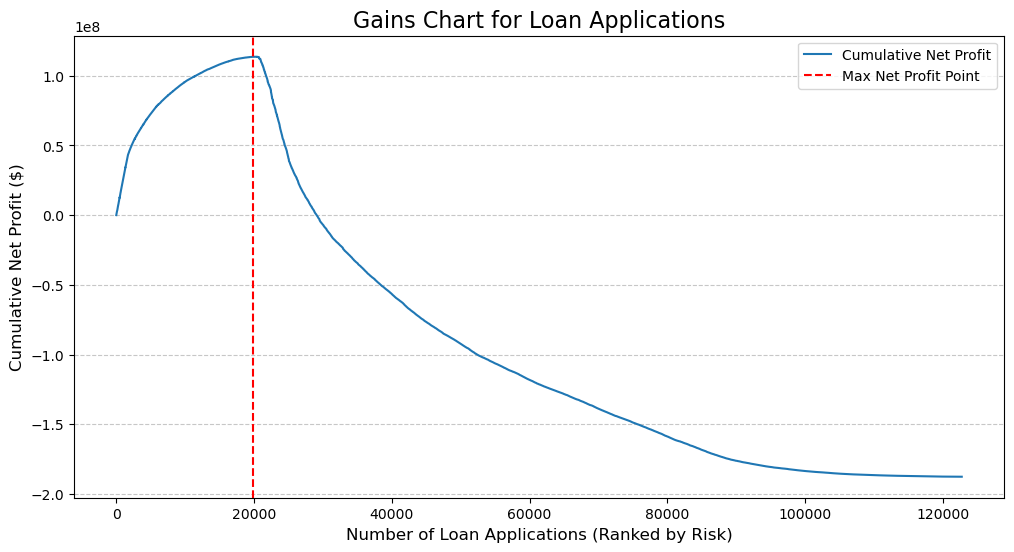

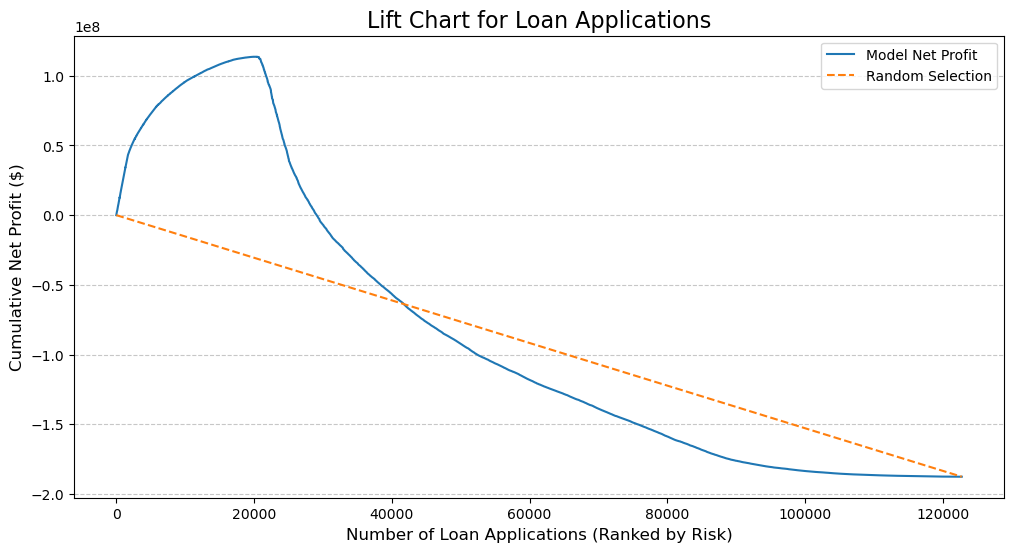

In [66]:
elastic_analysis = LoanApplicationProfitAnalysis(model=elastic, X_test=X_test, y_test=y_test, disbursement_test=disbursement_test)
cutoff_prob['ElasticNetLogistic'], max_apps['ElasticNetLogistic'], cost_matrix['ElasticNetLogistic'], max_profits['ElasticNetLogistic'] = elastic_analysis.analyze()

In [67]:
# Calculate net profit for Gradient Boosting Classifier
net_profits['ElasticNetLogistic'] = calculate_net_profit(y_test, y_pred_elastic, disbursement_test)
print(f"The Net Profit using ElasticNet Logistic Regression is: {net_profits['ElasticNetLogistic']:,.2f} USD")

The Net Profit using ElasticNet Logistic Regression is: 105,065,693.35 USD


In [68]:
print(f"Optimal Probability Cut-Off: {cutoff_prob['ElasticNetLogistic']:.2f}")

Optimal Probability Cut-Off: 0.65


In [69]:
print(f"Number of Applications to parse: {max_apps['ElasticNetLogistic']}")

Number of Applications to parse: 19875


In [70]:
print(f"The Maximum Profit for optimal Number of Applications using ElasticNet Logistic Regression is: {max_profits['ElasticNetLogistic']:,.2f} USD")

The Maximum Profit for optimal Number of Applications using ElasticNet Logistic Regression is: 113,659,971.96 USD


In [71]:
print(f"Cost Gain Matrix:\n {cost_matrix['ElasticNetLogistic']}")

Cost Gain Matrix:
          Scenario   Count Per Loan Gain/Loss ($) Total Gain/Loss ($)
0   True Positive   20542              $9,237.29     $189,752,486.27
1  False Positive     627            $-46,186.47     $-28,958,915.61
2   True Negative  100023                  $0.00               $0.00
3  False Negative    1553                  $0.00               $0.00


**ElasticNet Logistic Model Analysis**

1. Gains Chart Analysis
    - Trend: The cumulative net profit exhibits a sharp increase initially, reaching a peak at 19,875 loan applications, followed by a decline.
    - Optimal Point: The red dashed line highlights the maximum net profit at 19,875 applications, beyond which the profitability diminishes.

2. Lift Chart Analysis
    - Model vs. Random Baseline: The ElasticNet Logistic Regression model significantly outperforms random selection. The lift chart demonstrates the model's effectiveness in ranking and prioritizing profitable loans over less profitable ones.

3. Net Profit Evaluation
    - Profit Analysis: The ElasticNet Logistic Regression model achieves a net profit of 105,065,693.35 USD, primarily driven by true positives (189,752,486.27 USD). False positives contribute minor losses (28,958,915.61 USD).
    - Key Contributors: True positives remain the primary source of profit, with false positives having minimal adverse impact.

4. Optimal Probability and Loan Approval Range
    - Cutoff Probability: The optimal threshold of 0.65 effectively balances risk and reward, ensuring only high-probability applications are approved.
    - Loan Range: Approving 19,875 applications sustains profitability while minimizing exposure to riskier loans.
Insights: The model demonstrates effective decision-making when the 0.65 cutoff is applied.

5. Maximum Profit Analysis
    - Peak Profit: The maximum profit of 113,659,971.96 USD is achieved with 19,875 applications. Approving beyond this range leads to diminishing returns.
    - Strategies: Limit approvals to this optimal point and reassess thresholds for future data to maintain profitability.

6. Cost/Gain Matrix
    - True Positives (20,542): Contribute significantly to gains (189,752,486.27 USD).
    - False Positives (627): Result in small losses (28,958,915.61 USD) compared to gains.
    - False Negatives (1,553) and True Negatives (100,023): Minimal impact on overall profitability.

**Summary**
1. Approve loans up to 19,875 applications to achieve maximum profitability while avoiding riskier, less-profitable loans.
2. Use the 0.65 cutoff probability to optimize profitability and maintain decision-making efficiency.

### Neural Network

1. The number of hidden layers is arbitrary and depends on the problem being addressed. We performed a grid search over values ranging from 5 to 101 to determine the optimal value. 
2. We selected the 'adam' solver, which calculates the loss based on the stochastic gradient descent (SGD) curve. The activation function chosen was 'ReLU' (Rectified Linear Unit), a popular choice for complex classification problems with large datasets. 
3. The learning rate was also cross-validated through grid search, indicating that the model performs better when the learning rate remains consistent throughout.

In [72]:
from sklearn.neural_network import MLPClassifier

# Initialize and fit Neural Network
nn = MLPClassifier(hidden_layer_sizes=(51, 66), solver='adam', activation='relu', max_iter=500, \
                   learning_rate="constant", random_state=42)
nn.fit(X_train, y_train)

# Predict and evaluate
y_pred_nn = nn.predict(X_test)
print("Neural Network Classification Report:\n", classification_report(y_test, y_pred_nn))

Neural Network Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    100650
           1       0.97      0.98      0.98     22095

    accuracy                           0.99    122745
   macro avg       0.98      0.99      0.99    122745
weighted avg       0.99      0.99      0.99    122745



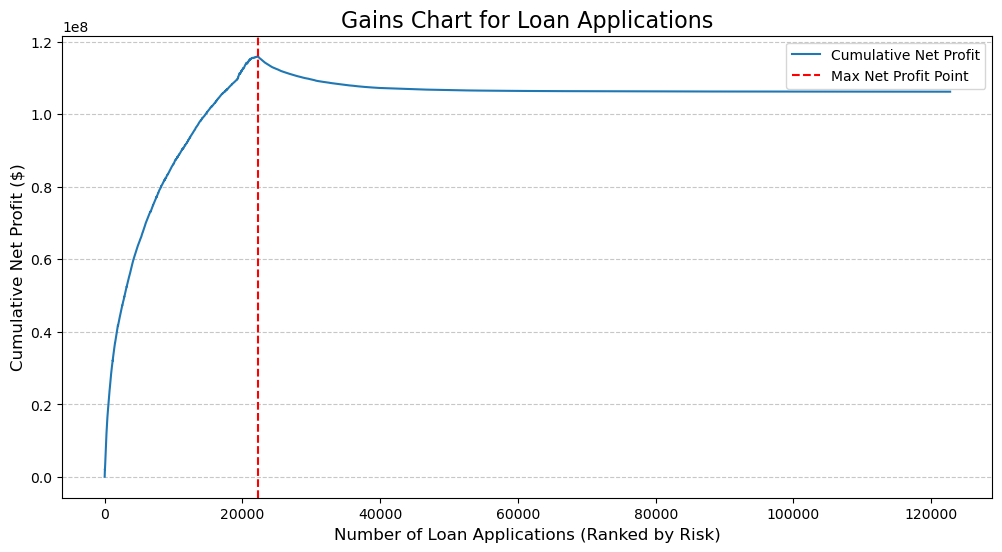

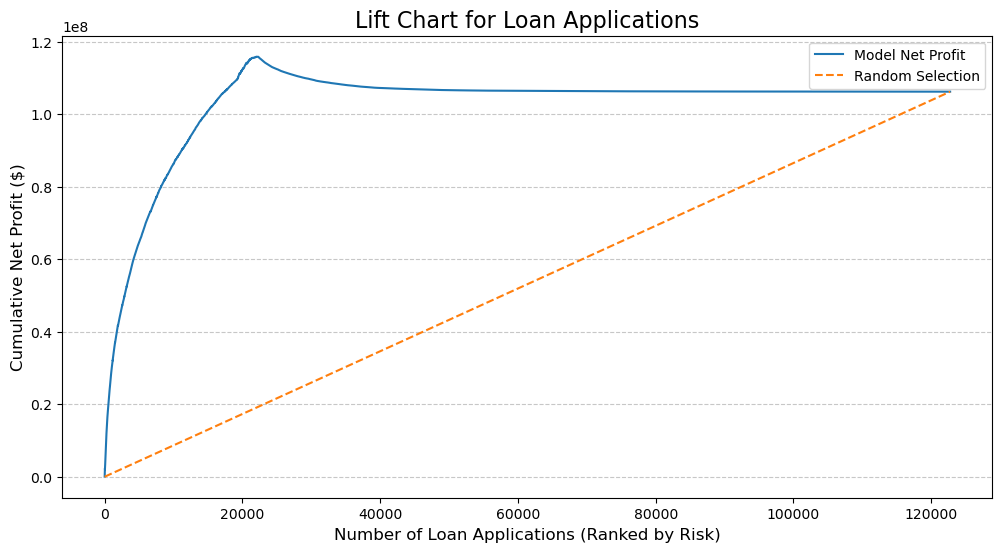

In [73]:
nn_analysis = LoanApplicationProfitAnalysis(model=nn, X_test=X_test, y_test=y_test, disbursement_test=disbursement_test)
cutoff_prob['NeuralNetwork'], max_apps['NeuralNetwork'], cost_matrix['NeuralNetwork'], max_profits['NeuralNetwork'] = nn_analysis.analyze()

In [74]:
# Calculate net profit for Neural Network
net_profits['NeuralNetwork'] = calculate_net_profit(y_test, y_pred_nn, disbursement_test)
print(f"The Net Profit using Neural Network is: {net_profits['NeuralNetwork']:,.2f} USD")

The Net Profit using Neural Network is: 116,232,116.80 USD


In [75]:
print(f"Optimal Probability Cut-Off: {cutoff_prob['NeuralNetwork']:.2f}")

Optimal Probability Cut-Off: 0.13


In [76]:
print(f"Number of Applications to parse: {max_apps['NeuralNetwork']}")

Number of Applications to parse: 22283


In [77]:
print(f"The Maximum Profit for optimal Number of Applications using Neural Network is: {max_profits['NeuralNetwork']:,.2f} USD")

The Maximum Profit for optimal Number of Applications using Neural Network is: 115,840,390.11 USD


In [78]:
print(f"Cost Gain Matrix:\n {cost_matrix['NeuralNetwork']}")

Cost Gain Matrix:
          Scenario   Count Per Loan Gain/Loss ($) Total Gain/Loss ($)
0   True Positive   21619              $9,237.29     $199,701,051.54
1  False Positive     565            $-46,186.47     $-26,095,354.58
2   True Negative  100085                  $0.00               $0.00
3  False Negative     476                  $0.00               $0.00


**Neural Network Model Analysis**

1. Gains Chart Analysis
    - Trend: The cumulative net profit rises steeply, peaking at 22,283 loan applications, followed by a plateau and slight decline.
    - Optimal Point: The red dashed line marks the maximum net profit at 22,283 applications, beyond which the profitability diminishes.

2. Lift Chart Analysis
    - Model vs. Random Baseline: The Neural Network model consistently outperforms random selection. The lift chart indicates the model's ability to rank profitable loans above less profitable ones effectively.

3. Net Profit Evaluation
    - Profit Analysis: The Neural Network achieves a net profit of 116,232,116.80 USD, with most gains driven by true positives (199,701,451.54 USD). Losses from false positives are relatively small (26,093,354.58 USD), showcasing the model's strong predictive ability.
    - Key Contributors: True positives are the major drivers of profitability, with minimal impact from false positives.

4. Optimal Probability and Loan Approval Range
    - Cutoff Probability: The optimal threshold of 0.13 balances risk and reward effectively, ensuring only high-confidence applications are approved.
    - Loan Range: Processing 22,283 applications ensures profitability while avoiding overextension into riskier applications.
    - Insights: Applying a 0.13 cutoff optimizes the model's decision-making for maximum profitability.

5. Maximum Profit Analysis
    - Peak Profit: The maximum profit of 115,840,390.11 USD is achieved with 22,283 applications. Beyond this, profitability declines slightly, signaling the optimal limit for approvals.
    - Strategies: Approve up to the optimal range and adjust thresholds for future datasets to sustain profitability.

6. Cost/Gain Matrix
    - True Positives (21,619): Contribute significantly to gains (199,701,451.54 USD).
    - False Positives (565): Cause relatively small losses (26,093,354.58 USD).
    - False Negatives (476) and True Negatives (100,085): Minimal impact on overall profitability.

**Summary**
1. Approve loans up to 22,283 applications to achieve maximum profitability while avoiding higher-risk, less-profitable applications.
2. Use the 0.13 cutoff probability to optimize profitability and decision-making.

### Linear Discriminant Analysis

In [79]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 

# Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)
print("Linear Discriminant Analysis Classification Report:\n", classification_report(y_test, y_pred_lda))

Linear Discriminant Analysis Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.77      0.86    100650
           1       0.46      0.90      0.61     22095

    accuracy                           0.80    122745
   macro avg       0.72      0.84      0.74    122745
weighted avg       0.88      0.80      0.82    122745



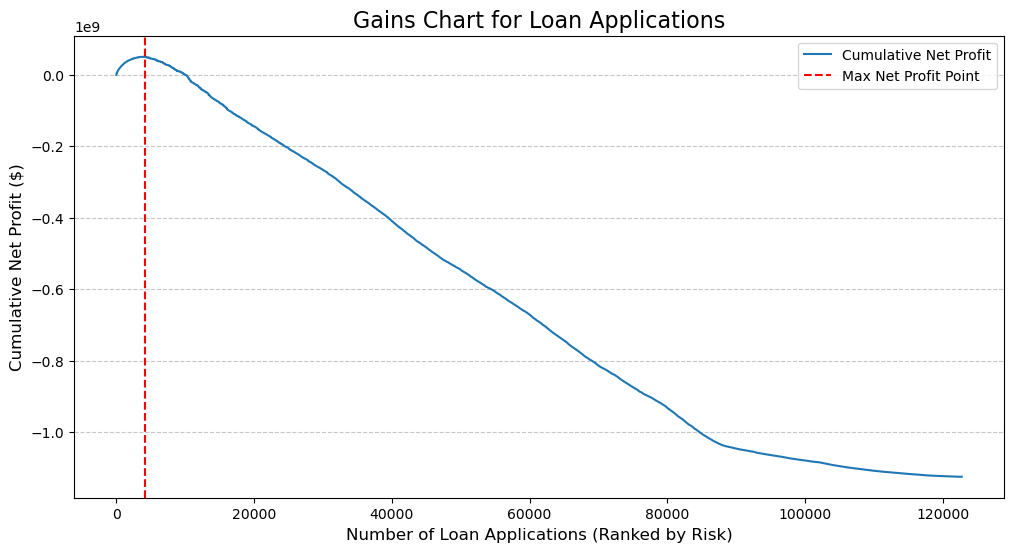

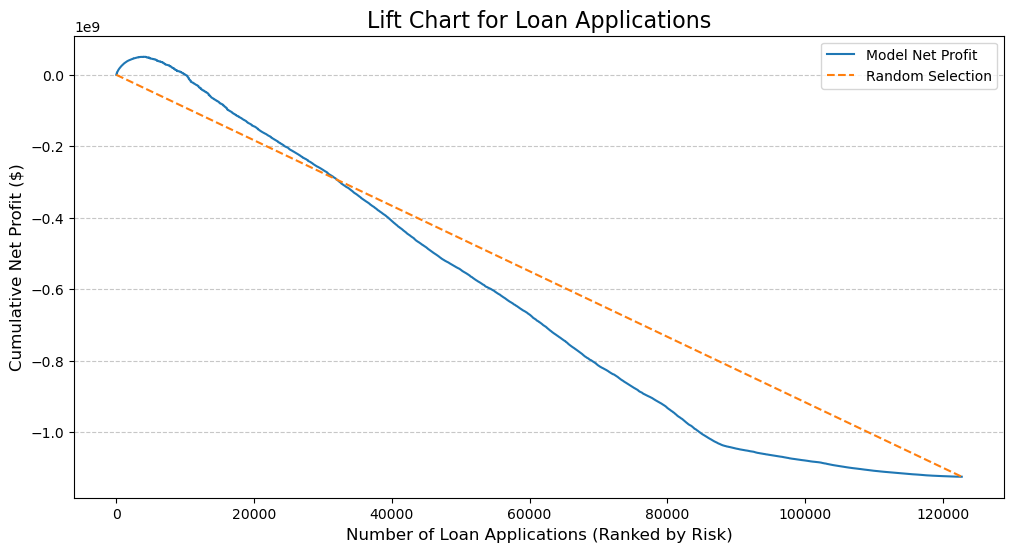

In [80]:
lda_analysis = LoanApplicationProfitAnalysis(model=lda, X_test=X_test, y_test=y_test, disbursement_test=disbursement_test)
cutoff_prob['LinearDiscriminant'], max_apps['LinearDiscriminant'], cost_matrix['LinearDiscriminant'], max_profits['LinearDiscriminant'] = lda_analysis.analyze()

In [81]:
# Calculate net profit for Linear Discriminant Analysis
net_profits['LinearDiscriminant'] = calculate_net_profit(y_test, y_pred_lda, disbursement_test)
print(f"The Net Profit using Linear Discriminant Analysis is: {net_profits['LinearDiscriminant']:,.2f} USD")

The Net Profit using Linear Discriminant Analysis is: -729,096,566.95 USD


In [82]:
print(f"Optimal Probability Cut-Off: {cutoff_prob['LinearDiscriminant']:.2f}")

Optimal Probability Cut-Off: 0.87


In [83]:
print(f"Number of Applications to parse: {max_apps['LinearDiscriminant']}")

Number of Applications to parse: 4170


In [84]:
print(f"The Maximum Profit for optimal Number of Applications using Linear Discriminant Analysis is: {max_profits['LinearDiscriminant']:,.2f} USD")

The Maximum Profit for optimal Number of Applications using Linear Discriminant Analysis is: 50,591,799.87 USD


In [85]:
print(f"Cost Gain Matrix:\n {cost_matrix['LinearDiscriminant']}")

Cost Gain Matrix:
          Scenario  Count Per Loan Gain/Loss ($) Total Gain/Loss ($)
0   True Positive  19886              $9,237.29     $183,692,821.63
1  False Positive  22932            $-46,186.47  $-1,059,148,090.54
2   True Negative  77718                  $0.00               $0.00
3  False Negative   2209                  $0.00               $0.00


**Linear Discriminant Analysis Model**

1. Gains Chart Analysis
    - Trend: The cumulative net profit declines rapidly after processing 4,170 loan applications, leading to negative profitability.
    - Optimal Point: The red dashed line indicates the maximum profit achieved at 4,170 applications before profitability starts diminishing further.

2. Lift Chart Analysis
    - Model vs. Random Baseline: The Linear Discriminant Analysis (LDA) model's performance aligns closely with the random baseline. This suggests limited ability of the model to rank loans based on profitability effectively.

3. Net Profit Evaluation
    - Profit Analysis: The LDA model results in a negative net profit of -729,096,566.95 USD, primarily due to high losses from false positives (1,059,148,000.54 USD). Gains from true positives (183,692,821.63 USD) are insufficient to offset these losses.
    - Key Contributors: False positives significantly impact the overall profitability, causing substantial financial losses.

4. Optimal Probability and Loan Approval Range
    - Cutoff Probability: The optimal threshold of 0.87 minimizes risk but still results in significant losses.
    - Loan Range: Limiting applications to 4,170 reduces negative impact but fails to achieve positive profitability.
    - Insights: Adjustments in feature selection and model parameters are necessary to improve the model's predictive capability.

5. Maximum Profit Analysis
    - Peak Profit: The maximum profit achieved is 50,591,799.87 USD at the optimal application range. Beyond this, profitability declines due to excessive false positives.
    - Strategies: Limit processing to the optimal range and consider alternative models or additional features to enhance prediction accuracy.

6. Cost/Gain Matrix
    - True Positives (18,986): Contribute 183,692,821.63 USD to gains.
    - False Positives (29,232): Cause significant losses of 1,059,148,000.54 USD.
    - False Negatives (2,209) and True Negatives (77,118): Minimal influence on overall results.

**Summary**
1. Negative Profitability: The LDA model's predictions result in negative net profits, with high false positive rates being the primary issue.
2. Limitations: Focus on enhancing the model or selecting more discriminative features to improve its ability to rank loans by risk and profitability.

### Quadratic Discriminant Analysis

In [86]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Quadratic Discriminant Analysis
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred_qda = qda.predict(X_test)
print("Quadratic Discriminant Analysis Classification Report:\n", classification_report(y_test, y_pred_qda))

Quadratic Discriminant Analysis Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98    100650
           1       0.91      0.92      0.91     22095

    accuracy                           0.97    122745
   macro avg       0.94      0.95      0.95    122745
weighted avg       0.97      0.97      0.97    122745



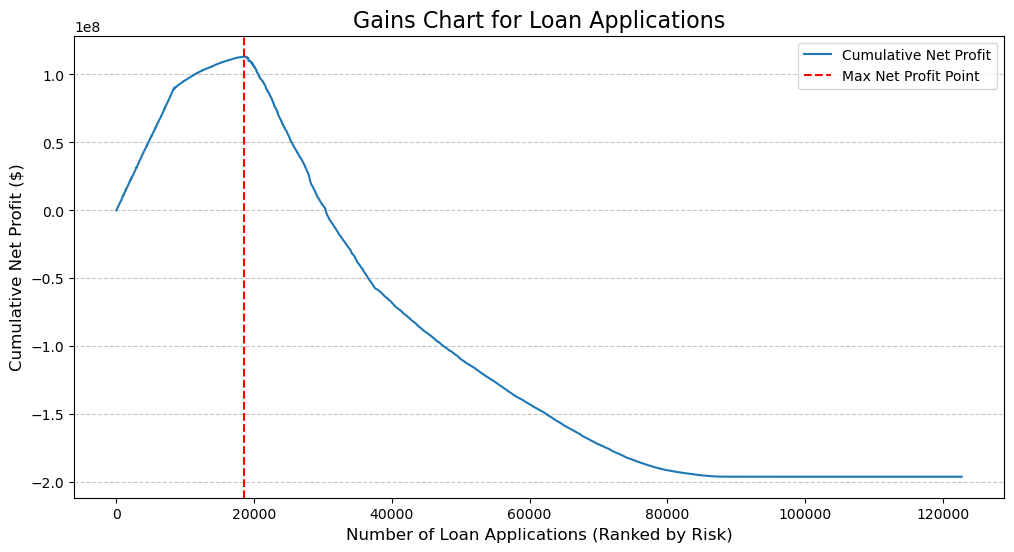

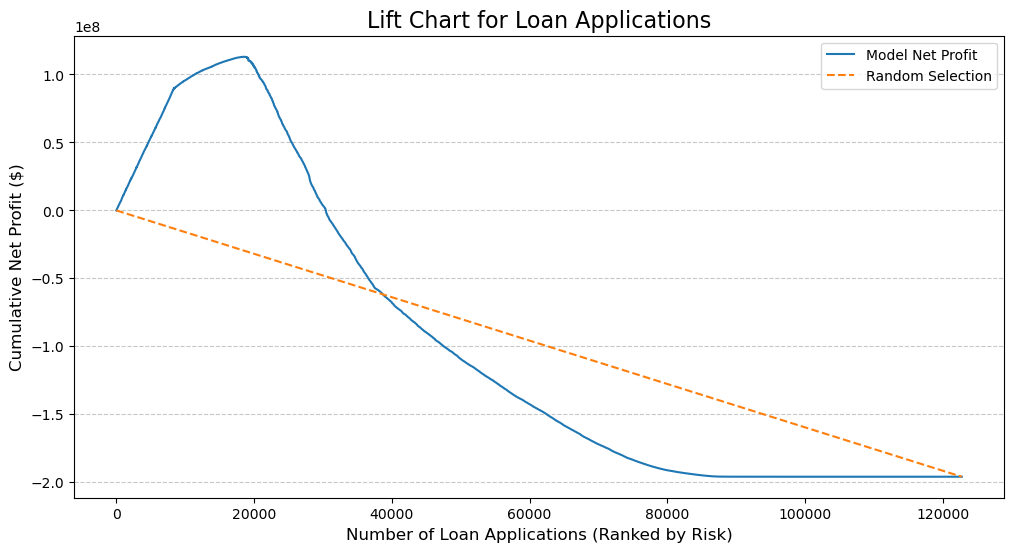

In [87]:
qda_analysis = LoanApplicationProfitAnalysis(model=qda, X_test=X_test, y_test=y_test, disbursement_test=disbursement_test)
cutoff_prob['QuadraticDiscriminant'], max_apps['QuadraticDiscriminant'], cost_matrix['QuadraticDiscriminant'], max_profits['QuadraticDiscriminant'] = qda_analysis.analyze()

In [88]:
# Calculate net profit for Quadratic Discriminant Analysis
net_profits['QuadraticDiscriminant'] = calculate_net_profit(y_test, y_pred_qda, disbursement_test)
print(f"The Net Profit using Quadratic Discriminant Analysis is: {net_profits['QuadraticDiscriminant']:,.2f} USD")

The Net Profit using Quadratic Discriminant Analysis is: 65,232,514.65 USD


In [89]:
print(f"Optimal Probability Cut-Off: {cutoff_prob['QuadraticDiscriminant']:.2f}")

Optimal Probability Cut-Off: 0.84


In [90]:
print(f"Number of Applications to parse: {max_apps['QuadraticDiscriminant']}")

Number of Applications to parse: 18540


In [91]:
print(f"The Maximum Profit for optimal Number of Applications using Quadratic Discriminant Analysis is: {max_profits['QuadraticDiscriminant']:,.2f} USD")

The Maximum Profit for optimal Number of Applications using Quadratic Discriminant Analysis is: 113,050,430.60 USD


In [92]:
print(f"Cost Gain Matrix:\n {cost_matrix['QuadraticDiscriminant']}")

Cost Gain Matrix:
          Scenario  Count Per Loan Gain/Loss ($) Total Gain/Loss ($)
0   True Positive  20303              $9,237.29     $187,544,773.09
1  False Positive   2067            $-46,186.47     $-95,467,429.93
2   True Negative  98583                  $0.00               $0.00
3  False Negative   1792                  $0.00               $0.00


**Quadratic Discriminant Model Analysis**

1. Gains Chart Analysis
    - Trend: The cumulative net profit shows a consistent increase, peaking at 18,540 applications, followed by a decline.
    - Optimal Point: The red dashed line highlights the maximum net profit achieved at 18,540 applications. Processing beyond this number leads to diminishing returns.

2. Lift Chart Analysis
    - Model vs. Random Baseline: The Quadratic Discriminant Analysis model consistently outperforms random selection, particularly for the top-ranked applications. The gap remains significant for most of the chart, indicating strong model performance.

3. Net Profit Evaluation
    - Profit Analysis: The Quadratic Discriminant Analysis achieves a net profit of 65,232,514.65 USD, with major gains attributed to true positives. Losses from false positives are moderate, indicating reliable predictions.
    - Key Contributors: A high true positive count and effective classification contribute to profitability, with minimal impact from false negatives.

4. Optimal Probability and Loan Approval Range
    - Cutoff Probability: The optimal threshold of 0.84 balances risk and reward effectively, ensuring only high-probability loans are approved.
    - Loan Range: With 18,540 applications processed, the model sustains profitability while minimizing risk.
    - Insights: Use the 0.84 cutoff to guide decisions and maintain profitability.

5. Maximum Profit Analysis
    - Peak Profit: The maximum profit of 113,050,430.60 USD is achieved at 18,540 applications. Approvals beyond this limit lead to reduced returns, indicating the model's optimal capacity.
    - Strategies: Reassess thresholds for future datasets to maintain and enhance profitability.

6. Cost/Gain Matrix
    - True Positives (20,303): Significant contributors, adding 187,544,773.09 USD to profits.
    - False Positives (2,067): Losses are 95,467,429.93 USD, offset by gains.
    - False Negatives (1,792): Minimal impact on profitability.
    - True Negatives (98,583): No associated cost.

**Summary**
1. Focus on processing up to 18,540 applications to maximize profitability while avoiding unnecessary losses.
2. The Quadratic Discriminant Analysis model effectively prioritizes high-quality applications. Using it to guide loan approvals ensures consistent and high returns compared to random selection.

### Visualizing the Net Profits of each model

In [93]:
# Display net profits
print("Net Profits for All Models:")
for model_name, profit in net_profits.items():
    print(f"{model_name}: ${profit:,.2f}")

Net Profits for All Models:
kNN: $-49,987,428.50
DecisionTree: $116,307,604.50
RandomForest: $113,016,941.00
Bagging: $116,307,604.50
Boosting: $116,307,604.50
XGBoosting: $116,372,293.10
RidgeLogistic: $115,629,050.45
LassoLogistic: $105,470,272.90
ElasticNetLogistic: $105,065,693.35
NeuralNetwork: $116,232,116.80
LinearDiscriminant: $-729,096,566.95
QuadraticDiscriminant: $65,232,514.65


In [94]:
# Separate profits and losses
profits = {key: value for key, value in net_profits.items() if value > 0}
losses = {key: value for key, value in net_profits.items() if value < 0}

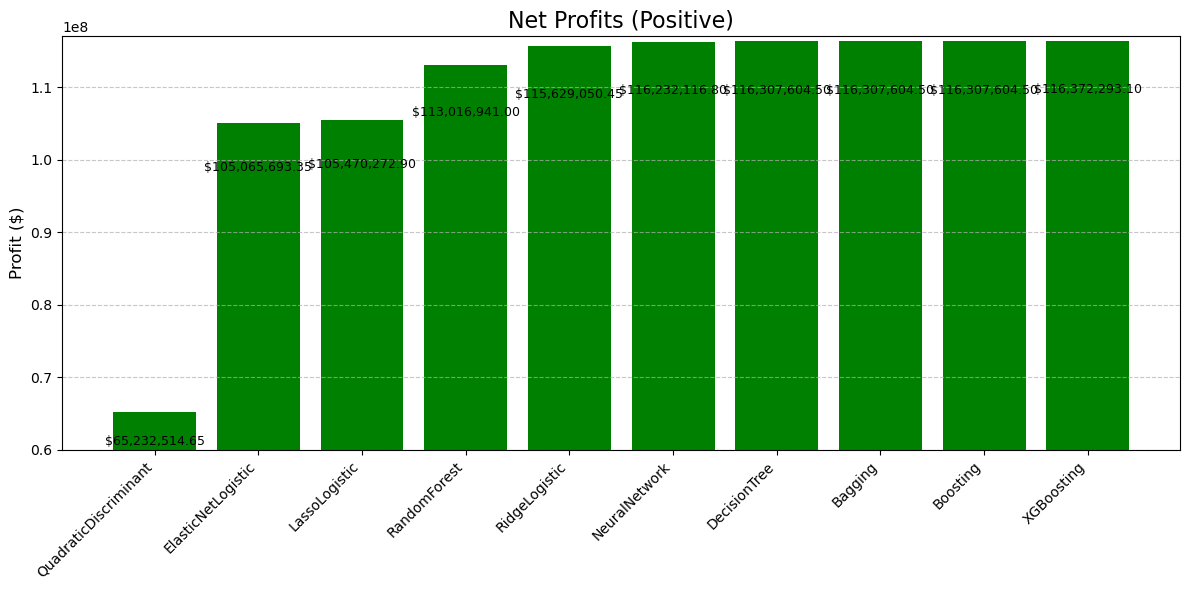

In [95]:
# Sort net profits in ascending order
sorted_net_profits = dict(sorted(profits.items(), key=lambda item: item[1]))

# Graph 1: Bar chart for profits with values inside bars
plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_net_profits.keys(), sorted_net_profits.values(), color='green')

# Add values inside bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval - (yval * 0.05), f"${yval:,.2f}",
             ha='center', va='top', fontsize=9, color='black')

# Set y-axis limits
plt.ylim(60000000, 117000000)

# Chart formatting
plt.title('Net Profits (Positive)', fontsize=16)
plt.ylabel('Profit ($)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

This bar chart shows the net profits (positive) achieved by different models in the loan approval analysis. 

1. XGBoost leads with the highest profit of 116.37M USD, followed closely by Bagging, Boosting, and Decision Tree models, each earning around 116.3M USD. 
2. Neural Network (116.23M USD) and Ridge Logistic Regression (115.63M USD) also perform well. 
3. Simpler models like Lasso and ElasticNet Logistic Regression generate lower profits (~105M USD), while QDA achieves the lowest at 65.23M USD. 

The chart highlights the superiority of ensemble methods for maximizing profitability.

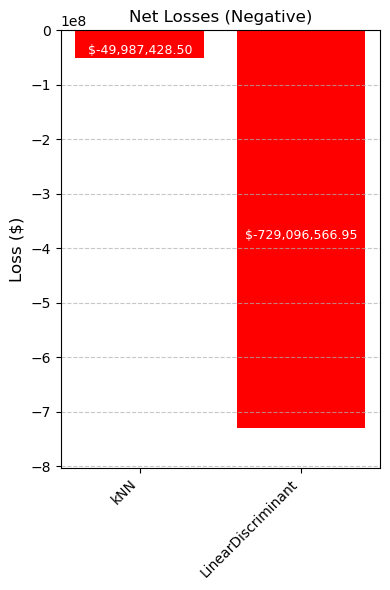

In [96]:
# Graph 2: Bar chart for losses with values inside bars
plt.figure(figsize=(4, 6))
bars = plt.bar(losses.keys(), losses.values(), color='red')

# Add values inside bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval - (yval * 0.5), f"${yval:,.2f}",
             ha='center', va='top', fontsize=9, color='white')

# Set y-axis to ensure the focus is on the loss range
plt.ylim(min(losses.values()) * 1.1, 0)

# Chart formatting
plt.title('Net Losses (Negative)', fontsize=12)
plt.ylabel('Loss ($)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

This bar chart visualizes the net losses (negative) incurred by the models.

1. k-Nearest Neighbors (kNN) resulted in a loss of 49.99M USD, reflecting its inability to effectively distinguish high-risk loans.

2. Linear Discriminant Analysis (LDA) incurred the largest loss at 729.10M USD, making it the least suitable model for this task.

The chart emphasizes the importance of selecting advanced models to minimize financial losses in loan approvals.

### Visualizing the Cut-off Probabilities of each model

In [97]:
# Display cut-off probabilities of all models
print("Cut-off Probabilities for All Models:")
for model_name, probability in cutoff_prob.items():
    print(f"{model_name}: {probability:,.2f}")

Cut-off Probabilities for All Models:
kNN: 0.96
DecisionTree: 0.92
RandomForest: 0.86
Bagging: 0.89
Boosting: 0.88
XGBoosting: 0.87
RidgeLogistic: 0.33
LassoLogistic: 0.64
ElasticNetLogistic: 0.65
NeuralNetwork: 0.13
LinearDiscriminant: 0.87
QuadraticDiscriminant: 0.84


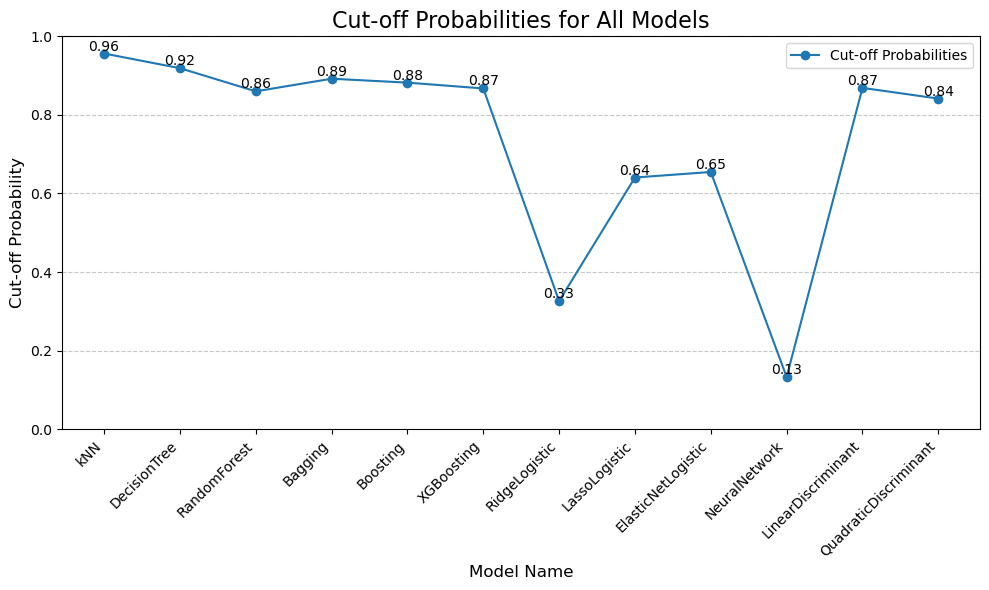

In [98]:
# Plotting the line chart
plt.figure(figsize=(10, 6))
x_values = list(cutoff_prob.keys())
y_values = list(cutoff_prob.values())

plt.plot(x_values, y_values, marker='o', linestyle='-', label="Cut-off Probabilities")
plt.title("Cut-off Probabilities for All Models", fontsize=16)
plt.xlabel("Model Name", fontsize=12)
plt.ylabel("Cut-off Probability", fontsize=12)
plt.ylim(0, 1)  # Ensuring the y-axis represents probabilities

# Adding values at each point
for x, y in zip(x_values, y_values):
    plt.text(x, y, f"{y:.2f}", fontsize=10, ha='center', va='bottom')  # Display values above points

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

The cut-off probabilities indicate the threshold for classifying loan approvals as "high risk" or "low risk" across various models:
1. Higher Cut-off Probabilities:
Models like kNN (0.96), DecisionTree (0.92), and RandomForest (0.86) have higher cut-offs, meaning they require high confidence to classify loans as low risk. These models are cautious in approving loans.

2. Moderate Cut-off Probabilities:
Models such as Bagging (0.89), Boosting (0.88), XGBoosting (0.87), and Quadratic Discriminant (0.84) fall in the middle range, balancing between risk and approval leniency.

3. Lower Cut-off Probabilities:
Neural Network (0.13), Ridge Logistic (0.33), and Lasso Logistic (0.64) have lower thresholds, making them more lenient and prone to approving loans with less confidence.

This visualization highlights the models' decision-making strictness and their approach to handling risk in loan approvals. Higher cut-offs signify conservative models, while lower cut-offs represent more aggressive or lenient approaches.

### Visualizing the Optimal Number of Applications to reach Max Profit of each model

In [99]:
# Display max number of applications of all models
print("Max Number of Applications for All Models:")
for model_name, applications in max_apps.items():
    print(f"{model_name}: {applications}")

Max Number of Applications for All Models:
kNN: 15417
DecisionTree: 22334
RandomForest: 22129
Bagging: 22378
Boosting: 22307
XGBoosting: 22402
RidgeLogistic: 22120
LassoLogistic: 20030
ElasticNetLogistic: 19875
NeuralNetwork: 22283
LinearDiscriminant: 4170
QuadraticDiscriminant: 18540


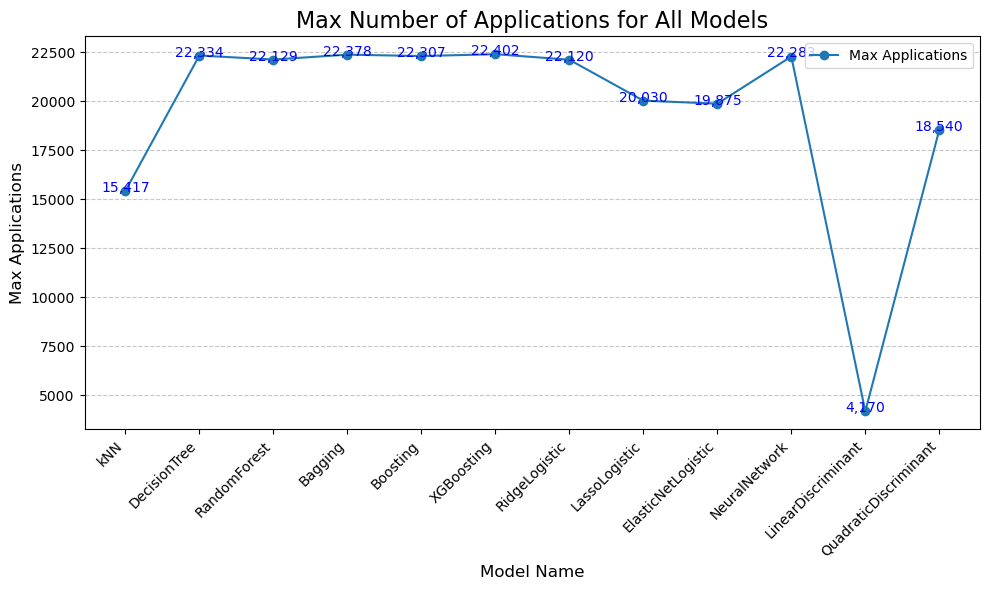

In [103]:
# Plotting the line chart
plt.figure(figsize=(10, 6))
x = list(max_apps.keys())
y = list(max_apps.values())

plt.plot(x, y, marker='o', linestyle='-', label="Max Applications")
plt.title("Max Number of Applications for All Models", fontsize=16)
plt.xlabel("Model Name", fontsize=12)
plt.ylabel("Max Applications", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Annotating values below the points
for i, value in enumerate(y):
    plt.text(x[i], value - 50, f"{value:,}", ha='center', fontsize=10, color="blue")

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend()
plt.tight_layout()
plt.show()

The chart visualizes the maximum number of applications processed for each model at the optimal cut-off probability. Here's an explanation based on the data and the graph:

1. Maximum Applications:
    - kNN: Processes the fewest applications (15,417) due to its high cut-off probability (0.96), making it more selective.
    - Linear Discriminant Analysis (LDA): Processes the least (4,170) due to its high cut-off probability (0.87) and prioritization of strict selection.
    - Quadratic Discriminant Analysis (QDA): Processes 18,540 applications, reflecting a balanced approach in its cut-off probability (0.84).
    - Models like DecisionTree, Bagging, RandomForest, Boosting, and XGBoost consistently process the maximum number of applications (around 22,300–22,400), indicating similar selection thresholds (around 0.86–0.92).
    - Ridge and ElasticNet Logistic Regression process slightly fewer (22,120–19,875) applications, reflecting their cut-off adjustments.

2. Trend Analysis:
    - Models with stricter thresholds (e.g., kNN, LDA) evaluate fewer applications, leading to reduced risk but potentially lower coverage.
    - Models with moderate cut-off probabilities process a higher number of applications, as seen with ensemble techniques like Bagging and Boosting.

The graph visually confirms the number of applications each model processes, emphasizing how the trade-off between cut-off probability and application count impacts overall performance.

### Visualizing the Max Profits of each model

In [101]:
# Display Max Profits of all models
print("Max Profits for All Models:")
for model_name, max_profit in max_profits.items():
    print(f"{model_name}: {max_profit:,.2f}")

Max Profits for All Models:
kNN: 41,089,180.19
DecisionTree: 116,418,883.68
RandomForest: 114,977,428.92
Bagging: 116,392,540.50
Boosting: 108,548,295.17
XGBoosting: 108,273,825.69
RidgeLogistic: 115,483,600.28
LassoLogistic: 113,707,552.73
ElasticNetLogistic: 113,659,971.96
NeuralNetwork: 115,840,390.11
LinearDiscriminant: 50,591,799.87
QuadraticDiscriminant: 113,050,430.60


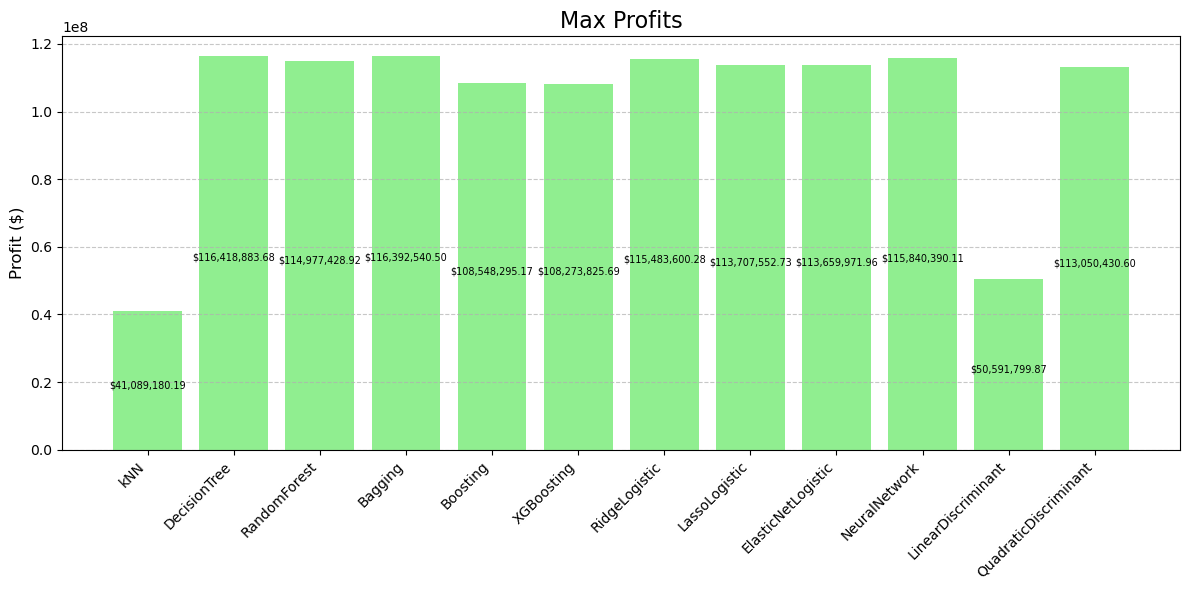

In [102]:
# Bar chart for Max Profits with values inside bars
plt.figure(figsize=(12, 6))
bars = plt.bar(max_profits.keys(), max_profits.values(), color='lightgreen')

# Add values inside bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval - (yval * 0.5), f"${yval:,.2f}",
             ha='center', va='top', fontsize=7, color='black')

# Chart formatting
plt.title('Max Profits', fontsize=16)
plt.ylabel('Profit ($)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Finding the Difference between Max Profits and Net Profits

In [122]:
# Calculate the differences and store them in a list of tuples
differences = [(key, abs(max_profits[key] - net_profits[key]), cutoff_prob[key]) for key in max_profits.keys()]

# Sort the list by the difference
differences.sort(key=lambda x: x[1])

# Print the results
for key, difference, cutoff in differences:
    print(f"{key} => Difference: {difference:,.2f}, Cut-off Probability: {cutoff:.2f}")

Bagging => Difference: 84,936.00, Cut-off Probability: 0.89
DecisionTree => Difference: 111,279.18, Cut-off Probability: 0.92
RidgeLogistic => Difference: 145,450.17, Cut-off Probability: 0.33
NeuralNetwork => Difference: 391,726.69, Cut-off Probability: 0.13
RandomForest => Difference: 1,960,487.92, Cut-off Probability: 0.86
Boosting => Difference: 7,759,309.33, Cut-off Probability: 0.88
XGBoosting => Difference: 8,098,467.41, Cut-off Probability: 0.87
LassoLogistic => Difference: 8,237,279.83, Cut-off Probability: 0.64
ElasticNetLogistic => Difference: 8,594,278.61, Cut-off Probability: 0.65
QuadraticDiscriminant => Difference: 47,817,915.95, Cut-off Probability: 0.84
kNN => Difference: 91,076,608.69, Cut-off Probability: 0.96
LinearDiscriminant => Difference: 779,688,366.82, Cut-off Probability: 0.87
